In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats.stats import pearsonr
import itertools
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
from sklearn import preprocessing
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from xgboost import plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn import svm
import Helper_Func as H
import tqdm
import scipy.stats
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
pd.options.display.max_rows = 410
pd.options.display.max_columns = 40

## Data Loading and Cleaning

We are interested in predicting whether a credit loan would be charged off given other attributes of the loan.

For data cleaning, we start with only considering loans that are either fully paid or charged off, since we do not know the future state of a loan in the process of being paid off or charged off. 

We notice that many columns are dense with missing values. We choose to drop all columns that consists of more than 90% missing values, and we further choose to drop all rows containing missing values, which is around 20% of all observations. We then would drop all the columns that satisfy at least one of the following criteria:  
    - Contains post-origination information  
    - Obviously does not relate to charge off information (e.g., ID)  
    - Is a categorical column containing many categories (greater than 50)  
    - Has a Pearson correlation of over 60%  
    
We apply transformations to the covariates to fit them into a standard normal distribution. These include log, square root, and cube root.

We then apply one-hot/dummy encoding to the categorical columns, dropping one column of each to avoid multicollinearity. We are left with a dataframe of 1090611 observations and 62 covariates plus the outcome variable.

See Helper_Func.py for the data cleaning function.

In [3]:
data = pd.read_csv("accepted_2007_to_2018Q4.csv")

/var/folders/_x/3kllznx55r73y92f0mnl7rf80000gn/T/ipykernel_1044/1048879327.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("accepted_2007_to_2018Q4.csv")


In [4]:
cleaned_data = H.CleanData(data,binary=True)

# Regression Analysis

Our first approach is logistic regression. We first run individual logistic regressions of loan_status against each covariate separately. We then select 53 out of 62 covariates with the greatest significance, indicated by the magnitude of the t-statistic, for a multiple logistic regression. Many of the coefficients of the most significant variables agree with intuition. For instance, borrowers with higher annual income or FICO score are less likely to default on their loan, while borrowers who take out larger loans are more likely to default.

In [5]:
splitdata=H.DataSplit(cleaned_data,0.1,0.1,seed=0)

In [6]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [7]:
# Set up statified data
X_train= trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [8]:
# Write a function to perform the logistic regression
# Inputs: 
#    X: 2D array
#    y: Charged Off variable (1d array)
# Output: [coefficient, t-value]

def regress_log(X, y):
    
    log_reg = sm.Logit(np.asarray(y), X).fit(disp=0)
    
    return [log_reg.params, log_reg.t_test('x1=0').tvalue]

In [9]:
names_list = cleaned_data.columns[0:len(cleaned_data.columns) - 1]

In [10]:
# Initialize results dataframe
reg_results = pd.DataFrame(np.zeros((len(names_list), 3)))
reg_results[0] = names_list
reg_results = reg_results.set_axis(['name','coef','t-stat'], axis = 1)

In [11]:
# Loop the regression over all variable names
for i in range(len(names_list)):
    X = np.array(X_train[names_list[i]]).reshape(-1,1)
    results = regress_log(X, y_train)
    
    reg_results['coef'][i] = results[0][0]
    reg_results['t-stat'][i] = np.abs(results[1][0])

/var/folders/_x/3kllznx55r73y92f0mnl7rf80000gn/T/ipykernel_1044/2475148548.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_results['coef'][i] = results[0][0]
/var/folders/_x/3kllznx55r73y92f0mnl7rf80000gn/T/ipykernel_1044/2475148548.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_results['t-stat'][i] = np.abs(results[1][0])
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
# Order the results by t-statistic
sorted_results = reg_results.sort_values(by = 't-stat', axis = 0, ascending = False)

top53 = sorted_results.head(53)
top53.head(10)

name      coef      t-stat
1             annual_inc -2.096081  528.571341
28        total_bc_limit -2.096377  528.083790
26        pct_tl_nvr_dlq -1.517808  525.355374
27     total_bal_ex_mort -2.032938  524.644810
8              revol_bal -2.286302  523.380107
18  mo_sin_old_rev_tl_op -2.729753  519.646421
17    mo_sin_old_il_acct -3.248907  517.489724
6               open_acc -2.620655  512.324056
2                    dti -3.233794  510.329565
23             num_bc_tl -2.982149  499.825562

In [13]:
names_53 = top53['name']

## Multiple Logistic Regression

We fit a multiple logistic regression model using the aforementioned 53 covariates on the training set, then predict loan_status for the test set. One issue we ran into here was that including 54 or more covariates would result in a singular matrix. We address this later by using ridge regression.  

The predictions give probabilities of default, which are between 0 and 1. In order to convert these probabilities to binary predictions, we use the receiver operating characteristic (ROC) curve to find the optimal probability threshold at which a loan should be predicted to default. In this case, the optimal threshold is 0.18702.  

From our predictions, we obtain a balanced accuracy score of 0.65122. We use the balanced accuracy score since the outcome variable, loan_status is unevenly split between the two categories - about 80% fully paid and 20% defaulted loans. The balanced accuracy formula rebalances the score to be between 0.5 and 1.

In [14]:
top_names = list(sorted_results.iloc[0:53]['name'].values)

In [15]:
#Using 53 covariates
log_reg_mult = sm.Logit(np.asarray(y_train), X_train[top_names]).fit(disp=0)

In [16]:
#Find optimal ROC cutoff
y_pred = log_reg_mult.predict(X_valid[top_names])

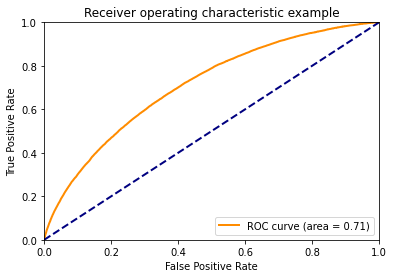

Optimal Threshold: 0.1897712108432384


In [17]:
thresh=H.ROC_cutoff(y_pred, y_valid)

In [18]:
# Get some accuracy metrics
log_reg_preds = (log_reg_mult.predict(X_test[top_names]) >= thresh[0][thresh[1]]).astype(int)
log_reg_BA = balanced_accuracy_score(y_test, log_reg_preds)
log_reg_recal = confusion_matrix(y_test, log_reg_preds)[1,1]/(confusion_matrix(y_test, log_reg_preds)[1,1]+confusion_matrix(y_test, log_reg_preds)[1,0])
log_reg_prec = confusion_matrix(y_test, log_reg_preds)[1,1]/(confusion_matrix(y_test, log_reg_preds)[1,1]+confusion_matrix(y_test, log_reg_preds)[0,1])
log_reg_F1 = 2 * log_reg_prec * log_reg_recal/(log_reg_prec+log_reg_recal)

In [19]:
print('Log Reg Balanced Accuracy:',log_reg_BA)
print('Log Reg F1:',log_reg_F1)
print('Log Reg Recall:',log_reg_recal)

Log Reg Balanced Accuracy: 0.6521534647235183
Log Reg F1: 0.41738527407586085
Log Reg Recall: 0.6626932835463641


In [20]:
print(log_reg_mult.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               872488
Model:                          Logit   Df Residuals:                   872435
Method:                           MLE   Df Model:                           52
Date:                Thu, 19 May 2022   Pseudo R-squ.:                 0.09082
Time:                        12:11:30   Log-Likelihood:            -3.8876e+05
converged:                       True   LL-Null:                   -4.2759e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
annual_inc                             -3.2490      0.144    -22.617      0.000      -3.531      -2.967
total_bc_limit                         -1.3086      0.07

In [21]:
lr_top15 = np.abs(log_reg_mult.params).sort_values(ascending=False).head(15).sort_values()

<Figure size 576x576 with 0 Axes>

<BarContainer object of 15 artists>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Unscaled Logistic Regression Coefficients')

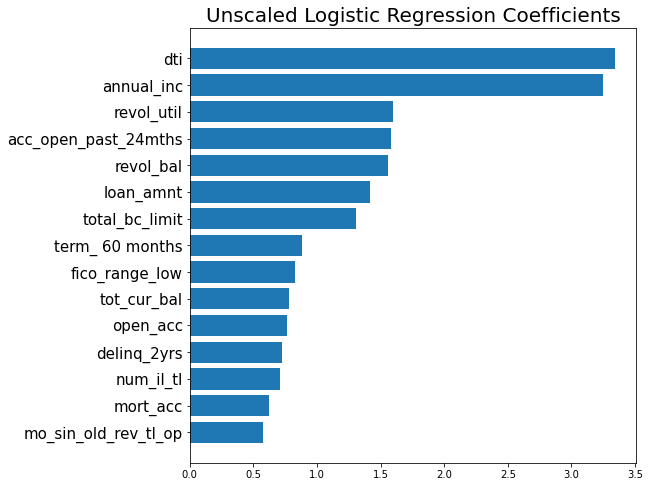

In [22]:
plt.figure(figsize=(8,8))
plt.barh(list(lr_top15.index),lr_top15)
plt.yticks(size=15)
plt.title("Unscaled Logistic Regression Coefficients", size=20)

## Multiple Logistic Regression With Interactions

Next, we explore the possibility of interactions within our data. In order to determine which interaction terms to include, we find the correlation between each pair of covariates and select the pairs with the highest magnitude of correlation. Our reasoning is that the more related two variables are, the more likely they are to have an underlying interaction.  

After including the interaction terms, we see a marginal increase in the balanced accuracy score to 0.65309 (previously 0.65122). 

In [23]:
def corr_analysis(data):
    correlations = {}
    names_list = data.columns[0:len(data.columns) - 1]
    for col_a, col_b in itertools.combinations(names_list, 2):
        correlations[col_a + '__' + col_b] = pearsonr(data.loc[:, col_a], data.loc[:, col_b])

    corr_result = pd.DataFrame.from_dict(correlations, orient='index')
    corr_result.columns = ['PCC', 'p-value']
    corr_result['abs_PCC'] = np.abs(corr_result['PCC'])
    top_20 = corr_result.sort_values('abs_PCC', ascending=False).head(20)
    return(top_20)

In [24]:
corr_result = corr_analysis(X_train[names_53])
# Drop the interactions between pairs from the same categorical column, as they would be all 0.
corr_result = corr_result.drop(['home_ownership_MORTGAGE__home_ownership_RENT',
                                'purpose_debt_consolidation__purpose_credit_card',
                                'verification_status_Source Verified__verification_status_Verified'], axis=0)
corr_result

PCC  p-value   abs_PCC
tot_cur_bal__mort_acc                  0.637524      0.0  0.637524
pct_tl_nvr_dlq__num_accts_ever_120_pd -0.622845      0.0  0.622845
tot_cur_bal__home_ownership_MORTGAGE   0.586099      0.0  0.586099
mort_acc__home_ownership_MORTGAGE      0.581781      0.0  0.581781
mo_sin_rcnt_tl__acc_open_past_24mths  -0.574404      0.0  0.574404
revol_bal__revol_util                  0.564104      0.0  0.564104
mort_acc__home_ownership_RENT         -0.559912      0.0  0.559912
tot_cur_bal__home_ownership_RENT      -0.555346      0.0  0.555346
total_bal_ex_mort__tot_cur_bal         0.541504      0.0  0.541504
total_bc_limit__revol_bal              0.540702      0.0  0.540702
total_bc_limit__num_bc_tl              0.532175      0.0  0.532175
total_bal_ex_mort__num_il_tl           0.531015      0.0  0.531015
annual_inc__tot_cur_bal                0.521186      0.0  0.521186
mo_sin_old_il_acct__num_il_tl          0.515638      0.0  0.515638
mths_since_recent_bc__mo_sin_rcnt_tl   0.510115      0.0  0.510115
total_bal_ex_mort__dti                 0.502535      0.0  0.502535
open_acc__num_bc_tl                    0.498927      0.0  0.498927

In [25]:
corr_names = list(corr_result.index)

In [26]:
# Create the interaction terms
for i in corr_names:
    two_names = i.split(sep = "__")
    X_train[i] = X_train[two_names[0]] * X_train[two_names[1]]
    X_test[i] = X_test[two_names[0]] * X_test[two_names[1]]
    X_valid[i] = X_valid[two_names[0]] * X_valid[two_names[1]]

In [27]:
#Some custom interactions we thought might have value
X_train['loan_amnt__fico_range_low'] = X_train['loan_amnt'] * X_train['fico_range_low']
X_test['loan_amnt__fico_range_low'] = X_test['loan_amnt'] * X_test['fico_range_low']
X_valid['loan_amnt__fico_range_low'] = X_valid['loan_amnt'] * X_valid['fico_range_low']
X_train['dti__fico_range_low'] = X_train['dti'] * X_train['fico_range_low']
X_test['dti__fico_range_low'] = X_test['dti'] * X_test['fico_range_low']
X_valid['dti__fico_range_low'] = X_valid['dti'] * X_valid['fico_range_low']


In [28]:
top_names = list(sorted_results.iloc[0:53]['name'].values)
top_names = np.append(top_names,corr_names)
manual_names = ['loan_amnt__fico_range_low','dti__fico_range_low']
top_names = np.append(top_names,manual_names)

In [29]:
#Using 53 covariates plus interaction terms
log_reg_mult = sm.Logit(np.asarray(y_train), X_train[top_names]).fit(disp=0)

In [30]:
#Find optimal ROC cutoff
y_pred = log_reg_mult.predict(X_valid[top_names])

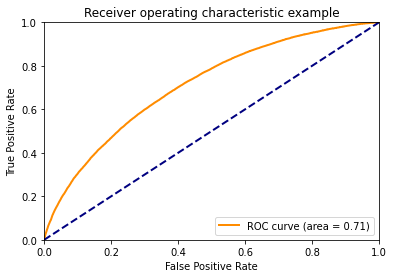

Optimal Threshold: 0.1869376980439968


In [31]:
thresh = H.ROC_cutoff(y_pred, y_valid)

In [32]:
# Accuracy metrics
log_reg_preds = (log_reg_mult.predict(X_test[top_names]) >= thresh[0][thresh[1]]).astype(int)
log_reg_BA = balanced_accuracy_score(y_test, log_reg_preds)
log_reg_recal = confusion_matrix(y_test, log_reg_preds)[1,1]/(confusion_matrix(y_test, log_reg_preds)[1,1]+confusion_matrix(y_test, log_reg_preds)[1,0])
log_reg_prec = confusion_matrix(y_test, log_reg_preds)[1,1]/(confusion_matrix(y_test, log_reg_preds)[1,1]+confusion_matrix(y_test, log_reg_preds)[0,1])
log_reg_F1 = 2 * log_reg_prec * log_reg_recal/(log_reg_prec+log_reg_recal)

In [33]:
print('Log Reg Balanced Accuracy:',log_reg_BA)
print('Log Reg F1:',log_reg_F1)
print('Log Reg Recall:',log_reg_recal)

Log Reg Balanced Accuracy: 0.653234867142355
Log Reg F1: 0.4181538507489434
Log Reg Recall: 0.6702092010148882


In [34]:
print(log_reg_mult.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               872488
Model:                          Logit   Df Residuals:                   872416
Method:                           MLE   Df Model:                           71
Date:                Thu, 19 May 2022   Pseudo R-squ.:                 0.09179
Time:                        12:11:48   Log-Likelihood:            -3.8834e+05
converged:                       True   LL-Null:                   -4.2759e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
annual_inc                               -1.5779      0.271     -5.816      0.000      -2.110      -1.046
total_bc_limit                           -2.2458  

# Ridge Regression

Due to issues with multicollinearity, we tried ridge regression along with standard logistic regression to adjust for  the design matrix which is almost singular.  

We obtain a balanced accuracy score of 0.65364, which slightly improves upon our multiple logistic model with interactions (0.65309).

In [35]:
splitdata=H.DataSplit(cleaned_data,0.1,0.1,seed=0)

In [36]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

## Parameter Fitting Code

In [37]:
# Used when fitting parameters
# Cutting down training data size
trainingdata = trainingdata.sample(frac=0.05, replace=False, random_state=1)
validationdata =  validationdata.sample(frac=1, replace=False, random_state=1)
testdata =  testdata.sample(frac=1, replace=False, random_state=1)

In [38]:
# Set up statified data
X_train = trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [39]:
def RidgeModelCV(X_train, y_train, X_valid, y_valid, alphas, weights):

    #with parallel_backend('threading', n_jobs=8):

        #10-fold Cross Validation to select the optimal penalty hyperparameter.
        #cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

        #Setting up model with sklearn using the penalty score obtained.
        #ridge_reg = RidgeClassifierCV(alphas=arange(1, 5, 0.1), cv=cv, scoring='neg_mean_absolute_error')

    BA_scores = np.zeros((len(alphas),len(weights)))
    rec_scores = np.zeros((len(alphas),len(weights)))
                          
    #Initialize our for loop to iterate through alpha values
    for i in range(len(alphas)):
        for j in range(len(weights)):
            ridge_reg = RidgeClassifier(alpha=alphas[i],class_weight={0:1,1:weights[j]})

            #Train the model.
            ridge_reg.fit(X_train, y_train)

            #Use the model to make prediction scores.
            ridge_reg_preds = ridge_reg._predict_proba_lr(X_valid)
            ridge_reg_preds = ridge_reg_preds[:,1]
            
            
            #Calculate ideal probability thresholds for each lambda
            ridge_reg_thresh = H.ROC_cutoff(ridge_reg_preds,y_valid, silence=True)
            temp1 = ridge_reg_thresh[0]
            temp2 = ridge_reg_thresh[1]
            ridge_reg_thresh = temp1[temp2]
            

            ridge_reg_preds = (ridge_reg_preds >= ridge_reg_thresh).astype(int)

            #Calculate balanced accuracy.
            BA_scores[i][j] = balanced_accuracy_score(y_valid, ridge_reg_preds)
            rec_scores[i][j] = confusion_matrix(y_valid, ridge_reg_preds)[1,1]/(confusion_matrix(y_valid, ridge_reg_preds)[1,1]+confusion_matrix(y_valid, ridge_reg_preds)[1,0])              

    #Check if logistic.
    best_alpha = alphas[np.argmax(np.max(BA_scores, axis=1))]
    best_weight = weights[np.argmax(np.max(BA_scores, axis=0))]

    return(best_alpha,best_weight)

In [40]:
alphas = np.arange(0, 5, 0.25)
weights = np.array([1,3,5])
best_alpha,best_weight = RidgeModelCV(X_train, y_train, X_valid, y_valid, alphas, weights)

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y 

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y 

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
print("Best Alpha:",best_alpha)
print("Best Weight:",best_weight)

Best Alpha: 2.5
Best Weight: 3


## Full Data Set Prediction

In [42]:
#Running Ridge Reg on full dataset on optimized hyperparameters
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]
# Set up statified data
X_train = trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

ridge_reg = RidgeClassifier(alpha=best_alpha,class_weight={0:1,1:best_weight})

#Train the model.
ridge_reg.fit(X_train, y_train)

#Use the model to make prediction scores.
ridge_reg_preds = ridge_reg._predict_proba_lr(X_test)
ridge_reg_preds = ridge_reg_preds[:,1]

#Calculate ideal probability thresholds for each lambda
ridge_reg_thresh = H.ROC_cutoff(ridge_reg_preds,y_test, silence=True)
temp1 = ridge_reg_thresh[0]
temp2 = ridge_reg_thresh[1]
ridge_reg_thresh = temp1[temp2]
            

ridge_reg_preds = (ridge_reg_preds >= ridge_reg_thresh).astype(int)

# Accuracy metrics
ridge_reg_BA = balanced_accuracy_score(y_test, ridge_reg_preds)
ridge_reg_recal = confusion_matrix(y_test, ridge_reg_preds)[1,1]/(confusion_matrix(y_test, ridge_reg_preds)[1,1]+confusion_matrix(y_test, ridge_reg_preds)[1,0])
ridge_reg_prec = confusion_matrix(y_test, ridge_reg_preds)[1,1]/(confusion_matrix(y_test, ridge_reg_preds)[1,1]+confusion_matrix(y_test, ridge_reg_preds)[0,1])
ridge_reg_F1 = 2 * ridge_reg_prec * ridge_reg_recal/(ridge_reg_prec+ridge_reg_recal)

print('Ridge Reg Balanced Accuracy:',ridge_reg_BA)
print('Ridge Reg F1:',ridge_reg_F1)
print('Ridge Reg Recall:',ridge_reg_recal)

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RidgeClassifier(alpha=2.5, class_weight={0: 1, 1: 3})

Ridge Reg Balanced Accuracy: 0.6536322684889782
Ridge Reg F1: 0.4204107931419232
Ridge Reg Recall: 0.640337019483939


## XGBoost

Due to the large number of covariates and our suspicion of non-linear relationships and collinearity within the data, we also wanted to try more advanced machine learning models. Our first approach is XGBoost (extreme gradient boosting) due to its performance on large data sets and data with outliers.

In [43]:
splitdata=H.DataSplit(cleaned_data,0.1,0.1,seed=0)

In [44]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

## Parameter Fitting Code

This does not need to be run. Note that this code is time consuming.  

XGBoost has two main parameters that require tuning: max_depth and eta. We perform a grid search to find the best values for each, which turn out to be max_depth = 2 and eta = 0.3.

In [45]:
# Used when fitting parameters
# Cutting down training data size
trainingdata = trainingdata.sample(frac=0.05, replace=False, random_state=1)
validationdata =  validationdata.sample(frac=1, replace=False, random_state=1)
testdata =  testdata.sample(frac=1, replace=False, random_state=1)

In [46]:
# Set up statified data
X_train= trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [47]:
# Code for parameter fitting
# May take a while to run
accur = [0]*100
FN = [0]*100
FP = [0]*100
F1 = [0]*100
prec = [0]*100
recal = [0]*100
BA = [0]*100
for i in range(1,11):
    for j in range(1,11):
        xgb_cl = xgb.XGBClassifier(use_label_encoder=False,booster='gbtree',verbosity=0,max_depth=i,eta=0.1*j,gamma=0)
        model = xgb_cl.fit(X_train,y_train)
        xgb_val = model.predict_proba(X_valid)[:,1]
        ROC=H.ROC_cutoff(xgb_val,y_valid, silence = True)
        thresholds = ROC[0]
        threshold = thresholds[ROC[1]]
        preds = (xgb_val >= threshold).astype(int)
        BA[10*(i-1)+(j-1)] = balanced_accuracy_score(y_valid, preds)

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pan

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pan

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pan

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pan

In [48]:
#BA.index(max(BA))
#max(BA)
eta = int(BA.index(max(BA)) % 10 + 1)
max_depth = int((BA.index(max(BA))-(eta-1))/10)+1
print("Optimum Max Depth:",max_depth)
print("Optimum Eta:",eta/10)

Optimum Max Depth: 2
Optimum Eta: 0.3


## Full Data Set Prediction

In [49]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [50]:
# Set up statified data
X_train= trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [51]:
# Fitting the full model - this may take several minutes
xgb_cl = xgb.XGBClassifier(use_label_encoder=False,booster='gbtree',verbosity=0,max_depth=2,eta=0.3,gamma=0)
model = xgb_cl.fit(X_train,y_train)

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [52]:
#ROC cutoff
xgb_val = model.predict_proba(X_valid)[:,1]
ROC=H.ROC_cutoff(xgb_val,y_valid, silence = True)
thresholds = ROC[0]
threshold = thresholds[ROC[1]]

In [53]:
#Check Model Accuracy
xgb_preds = (model.predict_proba(X_test)[:,1] >= threshold).astype(int)
xgb_prec = confusion_matrix(y_test, xgb_preds)[1,1]/(confusion_matrix(y_test, xgb_preds)[1,1]+confusion_matrix(y_test, xgb_preds)[0,1])
xgb_recal = confusion_matrix(y_test, xgb_preds)[1,1]/(confusion_matrix(y_test, xgb_preds)[1,1]+confusion_matrix(y_test, xgb_preds)[1,0])
xgb_F1 = 2 * xgb_prec * xgb_recal/(xgb_prec+xgb_recal)
xgb_BA = balanced_accuracy_score(y_test, xgb_preds)

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [54]:
print('XGB Balanced Accuracy:',xgb_BA)
print('XGB F1:',xgb_F1)
print('XGB Recall:',xgb_recal)

XGB Balanced Accuracy: 0.6575986835992438
XGB F1: 0.4235712206853239
XGB Recall: 0.6618794580879889


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

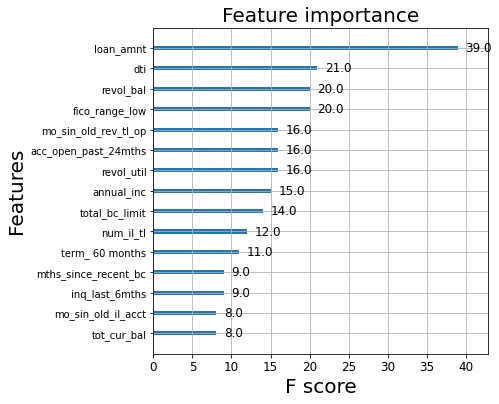

In [55]:
#Feature Importance
params = {'axes.labelsize': 20,'axes.titlesize':20, 'font.size': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 10}
ax = plt.rcParams.update(params)
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(model,max_num_features=15,ax=ax)

## Support Vector Machine (SVM)

We also applied a support vector machine (SVM) model. However due to the non-linear verisons uninterprebility we only experimented with linear SVM. In addition, training SVMs becomes extremely computationally expensive for larger datasets, so we train the data on a sample of 5% of the original training set.

In [56]:
splitdata=H.DataSplit(cleaned_data,0.1,0.1,seed=0)

In [57]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [58]:
# Used when fitting parameters
# Cutting down training data size
trainingdata = trainingdata.sample(frac=0.01, replace=False, random_state=1)
validationdata =  validationdata.sample(frac=1, replace=False, random_state=1)
testdata =  testdata.sample(frac=1, replace=False, random_state=1)

In [59]:
# Set up statified data
X_train = trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

## Parameter Fitting Code

This does not need to be run. Note that this code is time consuming.

We perform a grid search to find the best values for C and Class_Score, which turn out to be C = 0.01 and Class_Score = 5.


In [60]:
# Warning: This may take around half an hour to run
from statistics import mean
# With cross validation
k = 10
rng = np.random.default_rng(1) #setting the seed - for reproducability
shuffle = rng.choice(len(X_train), size=len(X_train), replace=False)
C = [10**-2,10**-1,0.5,1]
Class_Score = [4,5,6]
#C = [1,2]
#Class_Score = [1,2]

BA_scores = np.zeros((len(C),len(Class_Score)))
rec_scores = np.zeros((len(C),len(Class_Score)))

for c in range(len(C)):
    for s in range(len(Class_Score)):
        val_BA_list = []
        val_rec_list = []
        for i in range(k):
            svm_train_rows = shuffle[i:(i+1)*round(len(X_train)/k)]

            svm_X_train = X_train.iloc[svm_train_rows]
            svm_y_train = y_train.iloc[svm_train_rows]

            clf = svm.LinearSVC(C = C[c],class_weight={0:1,1:Class_Score[s]})
            clf.fit(svm_X_train,np.ravel(svm_y_train))
            svm_preds = clf.predict(X_valid)
            val_BA_list.append(balanced_accuracy_score(y_valid, svm_preds))
            val_rec_list.append(confusion_matrix(y_valid, svm_preds)[1,1]/(confusion_matrix(y_valid, svm_preds)[1,1]+confusion_matrix(y_valid, svm_preds)[1,0]))
        #print(c, mean(val_BA_list), mean(val_rec_list))
        BA_scores[c][s] = mean(val_BA_list)
        rec_scores[c][s] = mean(val_rec_list)

LinearSVC(C=0.01, class_weight={0: 1, 1: 4})

LinearSVC(C=0.01, class_weight={0: 1, 1: 4})

LinearSVC(C=0.01, class_weight={0: 1, 1: 4})

LinearSVC(C=0.01, class_weight={0: 1, 1: 4})

LinearSVC(C=0.01, class_weight={0: 1, 1: 4})

LinearSVC(C=0.01, class_weight={0: 1, 1: 4})

LinearSVC(C=0.01, class_weight={0: 1, 1: 4})

LinearSVC(C=0.01, class_weight={0: 1, 1: 4})

LinearSVC(C=0.01, class_weight={0: 1, 1: 4})

LinearSVC(C=0.01, class_weight={0: 1, 1: 4})

LinearSVC(C=0.01, class_weight={0: 1, 1: 5})

LinearSVC(C=0.01, class_weight={0: 1, 1: 5})

LinearSVC(C=0.01, class_weight={0: 1, 1: 5})

LinearSVC(C=0.01, class_weight={0: 1, 1: 5})

LinearSVC(C=0.01, class_weight={0: 1, 1: 5})

LinearSVC(C=0.01, class_weight={0: 1, 1: 5})

LinearSVC(C=0.01, class_weight={0: 1, 1: 5})

LinearSVC(C=0.01, class_weight={0: 1, 1: 5})

LinearSVC(C=0.01, class_weight={0: 1, 1: 5})

LinearSVC(C=0.01, class_weight={0: 1, 1: 5})

LinearSVC(C=0.01, class_weight={0: 1, 1: 6})

LinearSVC(C=0.01, class_weight={0: 1, 1: 6})

LinearSVC(C=0.01, class_weight={0: 1, 1: 6})

LinearSVC(C=0.01, class_weight={0: 1, 1: 6})

LinearSVC(C=0.01, class_weight={0: 1, 1: 6})

LinearSVC(C=0.01, class_weight={0: 1, 1: 6})

LinearSVC(C=0.01, class_weight={0: 1, 1: 6})

LinearSVC(C=0.01, class_weight={0: 1, 1: 6})

LinearSVC(C=0.01, class_weight={0: 1, 1: 6})

LinearSVC(C=0.01, class_weight={0: 1, 1: 6})

LinearSVC(C=0.1, class_weight={0: 1, 1: 4})

LinearSVC(C=0.1, class_weight={0: 1, 1: 4})

LinearSVC(C=0.1, class_weight={0: 1, 1: 4})

LinearSVC(C=0.1, class_weight={0: 1, 1: 4})

LinearSVC(C=0.1, class_weight={0: 1, 1: 4})

LinearSVC(C=0.1, class_weight={0: 1, 1: 4})

LinearSVC(C=0.1, class_weight={0: 1, 1: 4})

LinearSVC(C=0.1, class_weight={0: 1, 1: 4})

LinearSVC(C=0.1, class_weight={0: 1, 1: 4})

LinearSVC(C=0.1, class_weight={0: 1, 1: 4})

LinearSVC(C=0.1, class_weight={0: 1, 1: 5})

LinearSVC(C=0.1, class_weight={0: 1, 1: 5})

LinearSVC(C=0.1, class_weight={0: 1, 1: 5})

LinearSVC(C=0.1, class_weight={0: 1, 1: 5})

LinearSVC(C=0.1, class_weight={0: 1, 1: 5})

LinearSVC(C=0.1, class_weight={0: 1, 1: 5})

LinearSVC(C=0.1, class_weight={0: 1, 1: 5})

LinearSVC(C=0.1, class_weight={0: 1, 1: 5})

LinearSVC(C=0.1, class_weight={0: 1, 1: 5})

LinearSVC(C=0.1, class_weight={0: 1, 1: 5})

LinearSVC(C=0.1, class_weight={0: 1, 1: 6})

LinearSVC(C=0.1, class_weight={0: 1, 1: 6})

LinearSVC(C=0.1, class_weight={0: 1, 1: 6})

LinearSVC(C=0.1, class_weight={0: 1, 1: 6})

LinearSVC(C=0.1, class_weight={0: 1, 1: 6})

LinearSVC(C=0.1, class_weight={0: 1, 1: 6})

LinearSVC(C=0.1, class_weight={0: 1, 1: 6})

LinearSVC(C=0.1, class_weight={0: 1, 1: 6})

LinearSVC(C=0.1, class_weight={0: 1, 1: 6})

LinearSVC(C=0.1, class_weight={0: 1, 1: 6})

LinearSVC(C=0.5, class_weight={0: 1, 1: 4})

LinearSVC(C=0.5, class_weight={0: 1, 1: 4})

LinearSVC(C=0.5, class_weight={0: 1, 1: 4})

LinearSVC(C=0.5, class_weight={0: 1, 1: 4})

LinearSVC(C=0.5, class_weight={0: 1, 1: 4})

LinearSVC(C=0.5, class_weight={0: 1, 1: 4})

LinearSVC(C=0.5, class_weight={0: 1, 1: 4})

LinearSVC(C=0.5, class_weight={0: 1, 1: 4})

LinearSVC(C=0.5, class_weight={0: 1, 1: 4})

LinearSVC(C=0.5, class_weight={0: 1, 1: 4})

LinearSVC(C=0.5, class_weight={0: 1, 1: 5})

LinearSVC(C=0.5, class_weight={0: 1, 1: 5})

LinearSVC(C=0.5, class_weight={0: 1, 1: 5})

LinearSVC(C=0.5, class_weight={0: 1, 1: 5})

LinearSVC(C=0.5, class_weight={0: 1, 1: 5})

LinearSVC(C=0.5, class_weight={0: 1, 1: 5})

LinearSVC(C=0.5, class_weight={0: 1, 1: 5})

LinearSVC(C=0.5, class_weight={0: 1, 1: 5})

LinearSVC(C=0.5, class_weight={0: 1, 1: 5})

LinearSVC(C=0.5, class_weight={0: 1, 1: 5})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.5, class_weight={0: 1, 1: 6})

LinearSVC(C=0.5, class_weight={0: 1, 1: 6})

LinearSVC(C=0.5, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.5, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.5, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.5, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.5, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.5, class_weight={0: 1, 1: 6})

LinearSVC(C=0.5, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.5, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 4})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 4})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 4})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 4})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 4})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 4})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 4})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 4})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 4})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 4})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 5})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 5})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 5})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 5})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 5})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 5})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 5})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 5})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 5})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 5})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 6})

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, class_weight={0: 1, 1: 6})

In [61]:
print(BA_scores)
print(rec_scores)

[[0.63715232 0.63944762 0.63180059]
 [0.64111911 0.64327403 0.63766861]
 [0.64118686 0.64327194 0.63753846]
 [0.64116162 0.64301081 0.63731521]]
[[0.58773939 0.7064487  0.78966402]
 [0.59855534 0.69893076 0.77062681]
 [0.59986219 0.69597491 0.76331797]
 [0.60042294 0.69528109 0.76238179]]


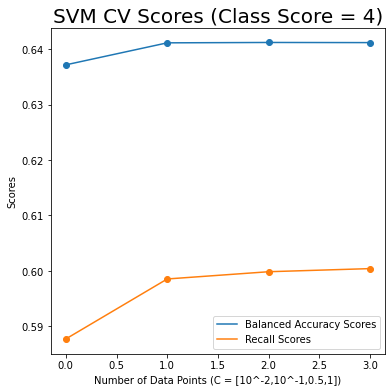

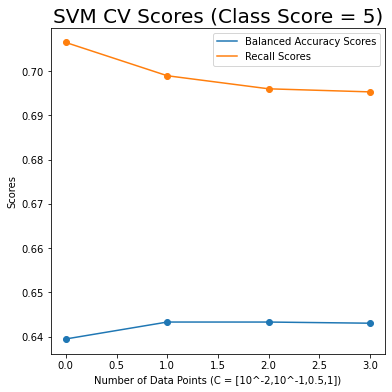

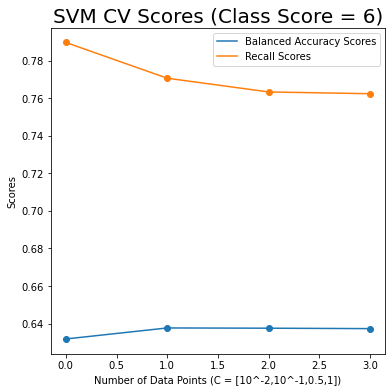

In [62]:
# SPAM scores plot
params = {'axes.labelsize': 10,'axes.titlesize':20, 'font.size': 10, 'xtick.labelsize': 10, 'ytick.labelsize': 10}
for i in range(len(Class_Score)):
    ax = plt.rcParams.update(params)
    ax = plt.figure(figsize=(6,6))
    ax = plt.scatter(range(len(rec_scores[:,i])),BA_scores[:,i])
    ax = plt.scatter(range(len(rec_scores[:,i])),rec_scores[:,i])
    ax = plt.plot(range(len(rec_scores[:,i])),BA_scores[:,i],label = "Balanced Accuracy Scores")
    ax = plt.plot(range(len(rec_scores[:,i])),rec_scores[:,i],label = "Recall Scores")
    ax = plt.title("SVM CV Scores (Class Score = " + str(Class_Score[i]) + ")")
    ax = plt.xlabel("Number of Data Points (C = [10^-2,10^-1,0.5,1])")
    ax = plt.ylabel("Scores")
    ax = plt.legend()
    plt.show()

In [63]:
# best_C = C[np.argmax(np.max(BA_scores, axis=1))]
# best_Class_Score = Class_Score[np.argmax(np.max(BA_scores, axis=0))]
best_C = 0.01
best_Class_Score = 5
print("Best C:", best_C)
print("Best Class Score:", best_Class_Score)

Best C: 0.01
Best Class Score: 5


## Full Data Set Prediction

In [64]:
clf = svm.LinearSVC(C = best_C,class_weight={0:1,1:best_Class_Score})
clf.fit(X_train,np.ravel(y_train))
svm_preds = clf.predict(X_test)

print("acc", accuracy_score(y_test, svm_preds))
print("FN", confusion_matrix(y_test, svm_preds)[1,0])
print("FP", confusion_matrix(y_test, svm_preds)[0,1])
print("prec", confusion_matrix(y_test, svm_preds)[1,1]/(confusion_matrix(y_test, svm_preds)[1,1]+confusion_matrix(y_test, svm_preds)[0,1]))
print("rec", confusion_matrix(y_test, svm_preds)[1,1]/(confusion_matrix(y_test, svm_preds)[1,1]+confusion_matrix(y_test, svm_preds)[1,0]))
#print("F1", 2 * prec[i-1] * recal[i-1]/(prec[i-1]+recal[i-1]))
print("BA", balanced_accuracy_score(y_test, svm_preds))

LinearSVC(C=0.01, class_weight={0: 1, 1: 5})

acc 0.6134767380022372
FN 6299
FP 35856
prec 0.2892201562066368
rec 0.6984537316290871
BA 0.6458993165647733


## SVM Coefficient Importance Plots

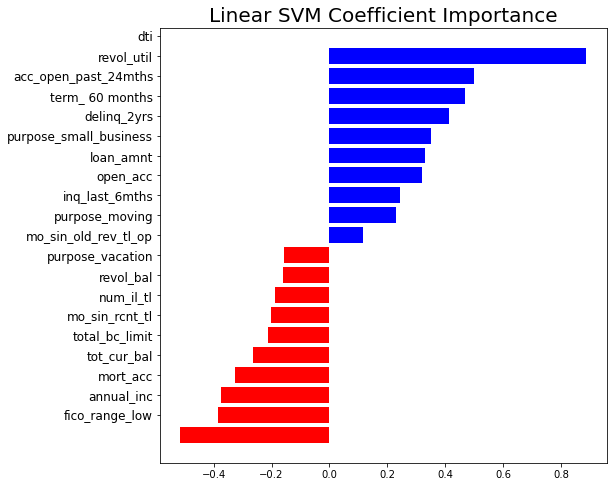

In [65]:
def plot_coefficients(classifier, feature_names, top_features=10):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(8, 8))
    colors = ['red'if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.barh(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.yticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], ha='right', size = 12)
    plt.title("Linear SVM Coefficient Importance")
    plt.show()
plot_coefficients(clf, X_train.columns)

<Figure size 576x576 with 0 Axes>

<BarContainer object of 15 artists>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Linear SVM Coefficients')

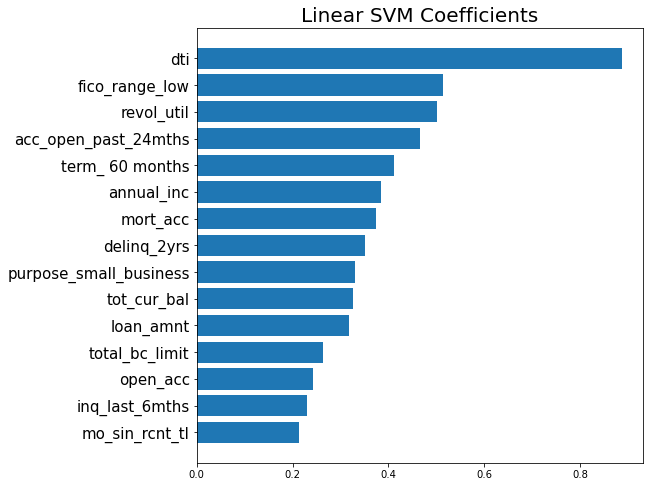

In [66]:
coef = np.abs(clf.coef_.ravel())
svm_coefs = pd.DataFrame(coef,X_train.columns).sort_values(by = 0, axis = 0, ascending = False).head(15).sort_values(by=0)
plt.figure(figsize=(8,8))
plt.barh(list(svm_coefs.index), svm_coefs[0])
plt.yticks(size=15)
plt.title("Linear SVM Coefficients", size=20)

We obtain a maximum balanced accuracy score of 0.64775, which is lower than our previous models. The SVM model assigns importance to features differently from previous models, but certain features remain similarly important, such as FICO score, annual income, dti, and loan amount.

# Subgrade Regression

In [67]:
#Valid responses
data_grade = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]

#Drop column if more than alpha are non-Null
alpha = 0.90

data_grade = data_grade.dropna(axis='columns',thresh = np.ceil(alpha*len(data_grade)))
data_grade = data_grade.dropna()

#Responce

data_grade = data_grade.replace({"Fully Paid":0,"Charged Off" :1})

data_grade = data_grade[["loan_status","sub_grade"]]
def ohe_columns(df, columns):
    """
    :param df: input data in the form of a dataframe
    :param columns: list of columns to encode
    :return: df: dataframe with the encoded columns
    """
    for col in columns:
        df = pd.concat([df.drop([col], axis=1),
                        pd.get_dummies(df[col],
                        drop_first=True, prefix=col)], axis=1)
    return df
    
data_grade = ohe_columns(data_grade,["sub_grade"])

In [68]:
splitdata=H.DataSplit(data_grade,0.1,0.1,seed=0)

In [69]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [70]:
# Set up statified data
X_train= trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [71]:
log_reg = sm.Logit(y_train, X_train).fit(disp=0)

In [72]:
#Find optimal ROC cutoff
y_pred = log_reg.predict(X_valid)

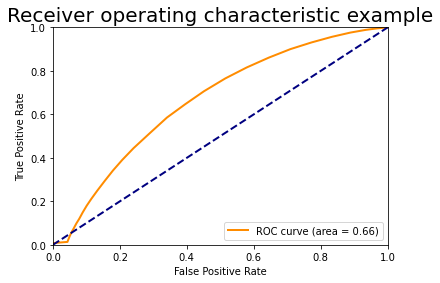

Optimal Threshold: 0.21830914442301846


In [73]:
thresh = H.ROC_cutoff(y_pred, y_valid)

In [74]:
# Get some accuracy metrics
log_reg_preds = (log_reg.predict(X_test) >= thresh[0][thresh[1]]).astype(int)
log_reg_BA = balanced_accuracy_score(y_test, log_reg_preds)
log_reg_recal = recall_score(y_test, log_reg_preds)
log_reg_F1 = f1_score(y_test, log_reg_preds)

In [75]:
print('Log Reg Balanced Accuracy:',log_reg_BA)
print('Log Reg F1:',log_reg_F1)
print('Log Reg Recall:',log_reg_recal)

Log Reg Balanced Accuracy: 0.6274371512980682
Log Reg F1: 0.3918547055586131
Log Reg Recall: 0.6476135765235291


# Bootstrap Model Robustness Check

We estimate the standard error for our machine learning models by calculating the Balanced Accuracy of our predictions on bootstrapped samples of our independent test set. We see that our XGBoost model outperforms our other models, including the Lending Club subgrade regression model.

## BOOTSTRAPPED TEST SAMPLES

In [76]:
splitdata=H.DataSplit(cleaned_data,0.1,0.1,seed=0)

In [77]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [78]:
# Set up statified data
X_train= trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [79]:
y = cleaned_data["loan_status"]
X = cleaned_data.drop(columns=["loan_status"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20,random_state=0)

In [80]:
top_names = list(sorted_results.iloc[0:53]['name'].values)
log_reg_mult = sm.Logit(np.asarray(y_train), X_train[top_names]).fit(disp=0)


## BOOTSTRAPPED REGRESSION

In [81]:
def reg(X_test, y_test):
    y_pred = log_reg_mult.predict(X_test[top_names])
    #Calculate ideal probability thresholds for each lambda

    log_reg_preds = (log_reg_mult.predict(X_test[top_names]) >= 0.18701962144751394).astype(int)
    log_reg_BA = balanced_accuracy_score(y_test, log_reg_preds)
    return log_reg_BA

In [82]:
B = 10000
n = len(X_test)
B_list = []
for i in tqdm.tqdm(range(B)):
    B_idx = np.random.choice(range(n), size=n, replace=True)
    B_list.append(reg(X_test.iloc[B_idx],y_test.iloc[B_idx]))

100%|█████████████████████████████████████| 10000/10000 [40:38<00:00,  4.10it/s]


In [83]:
len(B_list)

10000

In [84]:
B_list = np.array(B_list)
mean, sigma = np.mean(B_list), np.std(B_list)
scipy.stats.norm.interval(0.95, loc=mean, scale=sigma)

(0.6489599989067836, 0.6539759096985391)

In [85]:
max(B_list)

0.6565668809889593

## BOOTSTRAPPED SVM

In [86]:
best_C = 0.01
best_Class_Score = 5
clf = svm.LinearSVC(C = best_C,class_weight={0:1,1:best_Class_Score})
clf.fit(X_train,np.ravel(y_train))
B = 10000
n = len(X_test)
B_svm_list = []
for i in tqdm.tqdm(range(B)):
    B_idx = np.random.choice(range(n), size=n, replace=True)
    B_svm_list.append(balanced_accuracy_score(y_test.iloc[B_idx],clf.predict(X_test.iloc[B_idx])))
svm_preds = clf.predict(X_test)

LinearSVC(C=0.01, class_weight={0: 1, 1: 5})

100%|███████████████████████████████████| 10000/10000 [1:11:25<00:00,  2.33it/s]


In [87]:
B_svm_list = np.array(B_svm_list)
mean, sigma = np.mean(B_svm_list), np.std(B_svm_list)
scipy.stats.norm.interval(0.95, loc=mean, scale=sigma)

(0.6468341281245964, 0.6516706145545406)

## BOOTSTRAPPED XGB

In [88]:
# Fitting the full model - this may take several minutes
xgb_cl = xgb.XGBClassifier(use_label_encoder=False,booster='gbtree',verbosity=0,max_depth=2,eta=0.3,gamma=0)
model = xgb_cl.fit(X_train,y_train)

def XGB(X_test,y_test,model):
    xgb_val = model.predict_proba(X_valid)[:,1]
    ROC=H.ROC_cutoff(xgb_val,y_valid, silence = True)
    thresholds = ROC[0]
    threshold = thresholds[ROC[1]]
    xgb_preds = (model.predict_proba(X_test)[:,1] >= threshold).astype(int)
    return balanced_accuracy_score(y_test, xgb_preds)

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [89]:
B = 10000
n = len(X_test)
B_xgb_list = []
for i in tqdm.tqdm(range(B)):
    B_idx = np.random.choice(range(n), size=n, replace=True)
    B_xgb_list.append(XGB(X_test.iloc[B_idx],y_test.iloc[B_idx],model))

  0%|                                                 | 0/10000 [00:00<?, ?it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  0%|                                       | 1/10000 [00:00<1:17:09,  2.16it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  0%|                                      | 13/10000 [00:05<1:04:40,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  0%|                                      | 14/10000 [00:05<1:04:50,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  0%|                                      | 25/10000 [00:09<1:04:37,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  0%|                                      | 26/10000 [00:10<1:04:47,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  0%|▏                                     | 37/10000 [00:14<1:04:53,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  0%|▏                                     | 38/10000 [00:14<1:04:24,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  0%|▏                                     | 49/10000 [00:19<1:05:05,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  0%|▏                                     | 50/10000 [00:19<1:05:00,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  1%|▏                                     | 61/10000 [00:23<1:04:46,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  1%|▏                                     | 62/10000 [00:24<1:04:57,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  1%|▎                                     | 73/10000 [00:28<1:04:09,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  1%|▎                                     | 74/10000 [00:29<1:04:09,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  1%|▎                                     | 85/10000 [00:33<1:16:30,  2.16it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  1%|▎                                     | 86/10000 [00:34<1:15:52,  2.18it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  1%|▎                                     | 97/10000 [00:38<1:06:21,  2.49it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  1%|▎                                     | 98/10000 [00:39<1:06:30,  2.48it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  1%|▍                                    | 109/10000 [00:43<1:05:26,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  1%|▍                                    | 110/10000 [00:43<1:05:06,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  1%|▍                                    | 121/10000 [00:48<1:05:30,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  1%|▍                                    | 122/10000 [00:48<1:05:42,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  1%|▍                                    | 133/10000 [00:52<1:05:02,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  1%|▍                                    | 134/10000 [00:53<1:05:01,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  1%|▌                                    | 145/10000 [00:57<1:04:38,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  1%|▌                                    | 146/10000 [00:58<1:07:27,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  2%|▌                                    | 157/10000 [01:02<1:05:20,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  2%|▌                                    | 158/10000 [01:02<1:05:09,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  2%|▋                                    | 169/10000 [01:07<1:04:30,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  2%|▋                                    | 170/10000 [01:07<1:04:29,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  2%|▋                                    | 181/10000 [01:11<1:04:12,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  2%|▋                                    | 182/10000 [01:12<1:04:25,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  2%|▋                                    | 193/10000 [01:16<1:04:15,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  2%|▋                                    | 194/10000 [01:17<1:04:27,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  2%|▊                                    | 205/10000 [01:21<1:05:31,  2.49it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  2%|▊                                    | 206/10000 [01:21<1:05:36,  2.49it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  2%|▊                                    | 217/10000 [01:26<1:04:33,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  2%|▊                                    | 218/10000 [01:26<1:04:31,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  2%|▊                                    | 229/10000 [01:30<1:04:25,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  2%|▊                                    | 230/10000 [01:31<1:04:18,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  2%|▉                                    | 241/10000 [01:35<1:05:57,  2.47it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  2%|▉                                    | 242/10000 [01:36<1:05:43,  2.47it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  3%|▉                                    | 253/10000 [01:40<1:03:56,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  3%|▉                                    | 254/10000 [01:40<1:03:27,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  3%|▉                                    | 265/10000 [01:45<1:03:03,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  3%|▉                                    | 266/10000 [01:45<1:03:17,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  3%|█                                    | 277/10000 [01:49<1:03:46,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  3%|█                                    | 278/10000 [01:50<1:03:22,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  3%|█                                    | 289/10000 [01:54<1:04:20,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  3%|█                                    | 290/10000 [01:55<1:03:51,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  3%|█                                    | 301/10000 [01:59<1:03:54,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  3%|█                                    | 302/10000 [01:59<1:04:21,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  3%|█▏                                   | 313/10000 [02:04<1:11:55,  2.24it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  3%|█▏                                   | 314/10000 [02:05<1:10:58,  2.27it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  3%|█▏                                   | 325/10000 [02:09<1:06:08,  2.44it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  3%|█▏                                   | 326/10000 [02:09<1:05:40,  2.46it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  3%|█▏                                   | 337/10000 [02:14<1:07:19,  2.39it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  3%|█▎                                   | 338/10000 [02:14<1:06:39,  2.42it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  3%|█▎                                   | 349/10000 [02:19<1:04:07,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  4%|█▎                                   | 350/10000 [02:19<1:03:52,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  4%|█▎                                   | 361/10000 [02:24<1:03:20,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  4%|█▎                                   | 362/10000 [02:24<1:03:37,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  4%|█▍                                   | 373/10000 [02:28<1:02:31,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  4%|█▍                                   | 374/10000 [02:29<1:02:32,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  4%|█▍                                   | 385/10000 [02:33<1:02:59,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  4%|█▍                                   | 386/10000 [02:33<1:02:50,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  4%|█▍                                   | 397/10000 [02:38<1:03:16,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  4%|█▍                                   | 398/10000 [02:38<1:03:02,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  4%|█▌                                   | 409/10000 [02:43<1:04:05,  2.49it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  4%|█▌                                   | 410/10000 [02:43<1:03:40,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  4%|█▌                                   | 421/10000 [02:47<1:03:27,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  4%|█▌                                   | 422/10000 [02:48<1:05:27,  2.44it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  4%|█▌                                   | 433/10000 [02:52<1:02:54,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  4%|█▌                                   | 434/10000 [02:53<1:03:04,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  4%|█▋                                   | 445/10000 [02:57<1:05:05,  2.45it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  4%|█▋                                   | 446/10000 [02:57<1:04:35,  2.47it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  5%|█▋                                   | 457/10000 [03:02<1:04:30,  2.47it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  5%|█▋                                   | 458/10000 [03:02<1:04:04,  2.48it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  5%|█▋                                   | 469/10000 [03:07<1:03:39,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  5%|█▋                                   | 470/10000 [03:07<1:04:05,  2.48it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  5%|█▊                                   | 481/10000 [03:11<1:02:56,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  5%|█▊                                   | 482/10000 [03:12<1:03:01,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  5%|█▊                                   | 493/10000 [03:16<1:02:29,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  5%|█▊                                   | 494/10000 [03:17<1:02:34,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  5%|█▊                                   | 505/10000 [03:21<1:01:36,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  5%|█▊                                   | 506/10000 [03:21<1:01:35,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  5%|█▉                                   | 517/10000 [03:26<1:03:35,  2.49it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  5%|█▉                                   | 518/10000 [03:26<1:03:26,  2.49it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  5%|█▉                                   | 529/10000 [03:31<1:03:00,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  5%|█▉                                   | 530/10000 [03:31<1:02:31,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  5%|██                                   | 541/10000 [03:35<1:02:11,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  5%|██                                   | 542/10000 [03:36<1:02:02,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  6%|██                                   | 553/10000 [03:40<1:01:54,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  6%|██                                   | 554/10000 [03:40<1:01:51,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  6%|██                                   | 565/10000 [03:45<1:02:26,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  6%|██                                   | 566/10000 [03:45<1:01:56,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  6%|██▏                                  | 577/10000 [03:49<1:00:59,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  6%|██▏                                  | 578/10000 [03:50<1:01:39,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  6%|██▎                                    | 589/10000 [03:54<59:32,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  6%|██▏                                  | 590/10000 [03:54<1:00:09,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  6%|██▏                                  | 601/10000 [03:59<1:00:00,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  6%|██▎                                    | 602/10000 [03:59<59:50,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  6%|██▍                                    | 613/10000 [04:03<59:39,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  6%|██▍                                    | 614/10000 [04:04<59:31,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  6%|██▍                                    | 625/10000 [04:08<59:47,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  6%|██▍                                    | 626/10000 [04:08<59:33,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  6%|██▍                                    | 637/10000 [04:12<59:10,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  6%|██▍                                    | 638/10000 [04:13<59:01,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  6%|██▌                                    | 649/10000 [04:17<59:40,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  6%|██▌                                    | 650/10000 [04:17<59:23,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  7%|██▌                                    | 661/10000 [04:22<58:23,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  7%|██▌                                    | 662/10000 [04:22<59:00,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  7%|██▌                                    | 673/10000 [04:26<58:18,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  7%|██▋                                    | 674/10000 [04:26<58:22,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  7%|██▋                                    | 685/10000 [04:31<58:20,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  7%|██▋                                    | 686/10000 [04:31<58:06,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  7%|██▋                                    | 697/10000 [04:35<58:18,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  7%|██▋                                    | 698/10000 [04:35<58:05,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  7%|██▊                                    | 709/10000 [04:40<57:40,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  7%|██▊                                    | 710/10000 [04:40<57:36,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  7%|██▊                                    | 721/10000 [04:44<58:14,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  7%|██▊                                    | 722/10000 [04:44<57:48,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  7%|██▊                                    | 733/10000 [04:49<58:52,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  7%|██▊                                    | 734/10000 [04:49<59:08,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  7%|██▉                                    | 745/10000 [04:53<57:04,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  7%|██▉                                    | 746/10000 [04:53<57:42,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  8%|██▉                                    | 757/10000 [04:58<57:09,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  8%|██▉                                    | 758/10000 [04:58<57:08,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  8%|██▉                                    | 769/10000 [05:02<56:43,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  8%|███                                    | 770/10000 [05:02<56:37,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  8%|███                                    | 781/10000 [05:06<57:22,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  8%|███                                    | 782/10000 [05:07<57:09,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  8%|███                                    | 793/10000 [05:11<57:18,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  8%|███                                    | 794/10000 [05:11<56:46,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  8%|███▏                                   | 805/10000 [05:15<56:30,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  8%|███▏                                   | 806/10000 [05:16<56:27,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  8%|███▏                                   | 817/10000 [05:20<56:09,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  8%|███▏                                   | 818/10000 [05:20<56:55,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  8%|███▏                                   | 829/10000 [05:24<55:23,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  8%|███▏                                   | 830/10000 [05:25<55:34,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  8%|███▎                                   | 841/10000 [05:29<55:43,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  8%|███▎                                   | 842/10000 [05:29<55:39,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  9%|███▎                                   | 853/10000 [05:33<56:08,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  9%|███▎                                   | 854/10000 [05:33<55:46,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  9%|███▎                                   | 865/10000 [05:37<56:03,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  9%|███▍                                   | 866/10000 [05:38<55:44,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  9%|███▍                                   | 877/10000 [05:42<55:04,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  9%|███▍                                   | 878/10000 [05:42<55:19,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  9%|███▍                                   | 889/10000 [05:46<55:50,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  9%|███▍                                   | 890/10000 [05:47<55:32,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  9%|███▌                                   | 901/10000 [05:51<55:17,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  9%|███▌                                   | 902/10000 [05:51<55:22,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  9%|███▌                                   | 913/10000 [05:55<55:17,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  9%|███▌                                   | 914/10000 [05:55<55:20,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  9%|███▌                                   | 925/10000 [05:59<55:19,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  9%|███▌                                   | 926/10000 [06:00<55:03,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  9%|███▋                                   | 937/10000 [06:04<54:38,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
  9%|███▋                                   | 938/10000 [06:04<54:48,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

  9%|███▋                                   | 949/10000 [06:08<55:33,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 10%|███▋                                   | 950/10000 [06:08<56:00,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 10%|███▋                                   | 961/10000 [06:13<55:08,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 10%|███▊                                   | 962/10000 [06:13<54:46,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 10%|███▊                                   | 973/10000 [06:17<54:41,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 10%|███▊                                   | 974/10000 [06:17<54:36,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 10%|███▊                                   | 985/10000 [06:21<54:37,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 10%|███▊                                   | 986/10000 [06:22<54:50,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 10%|███▉                                   | 997/10000 [06:26<55:40,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 10%|███▉                                   | 998/10000 [06:26<55:04,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 10%|███▊                                  | 1009/10000 [06:30<54:40,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 10%|███▊                                  | 1010/10000 [06:30<54:54,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 10%|███▉                                  | 1021/10000 [06:34<54:31,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 10%|███▉                                  | 1022/10000 [06:35<54:35,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 10%|███▉                                  | 1033/10000 [06:39<54:33,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 10%|███▉                                  | 1034/10000 [06:39<54:41,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 10%|███▉                                  | 1045/10000 [06:43<54:06,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 10%|███▉                                  | 1046/10000 [06:44<53:52,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 11%|████                                  | 1057/10000 [06:48<55:42,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 11%|████                                  | 1058/10000 [06:48<55:05,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 11%|████                                  | 1069/10000 [06:52<54:03,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 11%|████                                  | 1070/10000 [06:52<54:12,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 11%|████                                  | 1081/10000 [06:56<55:17,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 11%|████                                  | 1082/10000 [06:57<54:48,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 11%|████▏                                 | 1093/10000 [07:01<54:00,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 11%|████▏                                 | 1094/10000 [07:01<53:44,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 11%|████▏                                 | 1105/10000 [07:05<54:02,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 11%|████▏                                 | 1106/10000 [07:05<53:54,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 11%|████▏                                 | 1117/10000 [07:09<53:30,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 11%|████▏                                 | 1118/10000 [07:10<53:17,  2.78it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 11%|████▎                                 | 1129/10000 [07:14<54:39,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 11%|████▎                                 | 1130/10000 [07:14<54:04,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 11%|████▎                                 | 1141/10000 [07:18<53:18,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 11%|████▎                                 | 1142/10000 [07:19<53:55,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 12%|████▍                                 | 1153/10000 [07:23<55:10,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 12%|████▍                                 | 1154/10000 [07:23<54:55,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 12%|████▍                                 | 1165/10000 [07:27<54:07,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 12%|████▍                                 | 1166/10000 [07:27<54:01,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 12%|████▍                                 | 1177/10000 [07:31<53:57,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 12%|████▍                                 | 1178/10000 [07:32<53:55,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 12%|████▌                                 | 1189/10000 [07:36<53:28,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 12%|████▌                                 | 1190/10000 [07:36<53:27,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 12%|████▌                                 | 1201/10000 [07:40<53:17,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 12%|████▌                                 | 1202/10000 [07:41<54:10,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 12%|████▌                                 | 1213/10000 [07:45<54:34,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 12%|████▌                                 | 1214/10000 [07:45<53:55,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 12%|████▋                                 | 1225/10000 [07:49<54:33,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 12%|████▋                                 | 1226/10000 [07:50<53:52,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 12%|████▋                                 | 1237/10000 [07:54<54:31,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 12%|████▋                                 | 1238/10000 [07:54<57:34,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 12%|████▋                                 | 1249/10000 [07:58<53:55,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 12%|████▊                                 | 1250/10000 [07:58<53:33,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 13%|████▊                                 | 1261/10000 [08:02<54:02,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 13%|████▊                                 | 1262/10000 [08:03<54:10,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 13%|████▊                                 | 1273/10000 [08:07<53:05,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 13%|████▊                                 | 1274/10000 [08:07<53:15,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 13%|████▉                                 | 1285/10000 [08:11<53:25,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 13%|████▉                                 | 1286/10000 [08:12<53:49,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 13%|████▉                                 | 1297/10000 [08:16<52:41,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 13%|████▉                                 | 1298/10000 [08:16<53:40,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 13%|████▉                                 | 1309/10000 [08:20<52:35,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 13%|████▉                                 | 1310/10000 [08:20<52:40,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 13%|█████                                 | 1321/10000 [08:25<52:58,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 13%|█████                                 | 1322/10000 [08:25<53:29,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 13%|█████                                 | 1333/10000 [08:29<53:15,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 13%|█████                                 | 1334/10000 [08:29<53:04,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 13%|█████                                 | 1345/10000 [08:33<54:04,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 13%|█████                                 | 1346/10000 [08:34<53:23,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 14%|█████▏                                | 1357/10000 [08:38<52:42,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 14%|█████▏                                | 1358/10000 [08:38<52:44,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 14%|█████▏                                | 1369/10000 [08:42<53:00,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 14%|█████▏                                | 1370/10000 [08:43<52:42,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 14%|█████▏                                | 1381/10000 [08:47<53:51,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 14%|█████▎                                | 1382/10000 [08:47<53:56,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 14%|█████▎                                | 1393/10000 [08:51<52:32,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 14%|█████▎                                | 1394/10000 [08:51<52:14,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 14%|█████▎                                | 1405/10000 [08:56<52:30,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 14%|█████▎                                | 1406/10000 [08:56<52:25,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 14%|█████▍                                | 1417/10000 [09:00<52:32,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 14%|█████▍                                | 1418/10000 [09:00<52:29,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 14%|█████▍                                | 1429/10000 [09:04<53:21,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 14%|█████▍                                | 1430/10000 [09:05<52:46,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 14%|█████▍                                | 1441/10000 [09:09<51:45,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 14%|█████▍                                | 1442/10000 [09:09<51:50,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 15%|█████▌                                | 1453/10000 [09:13<52:15,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 15%|█████▌                                | 1454/10000 [09:13<52:02,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 15%|█████▌                                | 1465/10000 [09:17<52:17,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 15%|█████▌                                | 1466/10000 [09:18<51:56,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 15%|█████▌                                | 1477/10000 [09:22<52:11,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 15%|█████▌                                | 1478/10000 [09:22<52:17,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 15%|█████▋                                | 1489/10000 [09:26<51:50,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 15%|█████▋                                | 1490/10000 [09:27<52:00,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 15%|█████▋                                | 1501/10000 [09:31<51:23,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 15%|█████▋                                | 1502/10000 [09:31<51:22,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 15%|█████▋                                | 1513/10000 [09:35<51:28,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 15%|█████▊                                | 1514/10000 [09:35<51:24,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 15%|█████▊                                | 1525/10000 [09:39<51:29,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 15%|█████▊                                | 1526/10000 [09:40<51:42,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 15%|█████▊                                | 1537/10000 [09:44<51:16,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 15%|█████▊                                | 1538/10000 [09:44<51:08,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 15%|█████▉                                | 1549/10000 [09:48<51:09,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 16%|█████▉                                | 1550/10000 [09:49<51:28,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 16%|█████▉                                | 1561/10000 [09:53<52:06,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 16%|█████▉                                | 1562/10000 [09:53<52:12,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 16%|█████▉                                | 1573/10000 [09:57<51:41,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 16%|█████▉                                | 1574/10000 [09:57<51:36,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 16%|██████                                | 1585/10000 [10:01<51:06,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 16%|██████                                | 1586/10000 [10:02<51:33,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 16%|██████                                | 1597/10000 [10:06<51:38,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 16%|██████                                | 1598/10000 [10:06<51:12,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 16%|██████                                | 1609/10000 [10:10<51:11,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 16%|██████                                | 1610/10000 [10:11<51:22,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 16%|██████▏                               | 1621/10000 [10:15<51:07,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 16%|██████▏                               | 1622/10000 [10:15<50:51,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 16%|██████▏                               | 1633/10000 [10:19<51:27,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 16%|██████▏                               | 1634/10000 [10:19<51:15,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 16%|██████▎                               | 1645/10000 [10:23<51:36,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 16%|██████▎                               | 1646/10000 [10:24<51:30,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 17%|██████▎                               | 1657/10000 [10:28<51:06,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 17%|██████▎                               | 1658/10000 [10:28<51:05,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 17%|██████▎                               | 1669/10000 [10:32<50:46,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 17%|██████▎                               | 1670/10000 [10:33<51:08,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 17%|██████▍                               | 1681/10000 [10:37<51:09,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 17%|██████▍                               | 1682/10000 [10:37<50:39,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 17%|██████▍                               | 1693/10000 [10:41<50:46,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 17%|██████▍                               | 1694/10000 [10:41<50:23,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 17%|██████▍                               | 1705/10000 [10:45<49:52,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 17%|██████▍                               | 1706/10000 [10:46<49:44,  2.78it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 17%|██████▌                               | 1717/10000 [10:50<50:42,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 17%|██████▌                               | 1718/10000 [10:50<50:30,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 17%|██████▌                               | 1729/10000 [10:54<50:20,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 17%|██████▌                               | 1730/10000 [10:55<50:37,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 17%|██████▌                               | 1741/10000 [10:59<50:03,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 17%|██████▌                               | 1742/10000 [10:59<49:46,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 18%|██████▋                               | 1753/10000 [11:03<50:17,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 18%|██████▋                               | 1754/10000 [11:03<50:10,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 18%|██████▋                               | 1765/10000 [11:07<50:04,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 18%|██████▋                               | 1766/10000 [11:08<49:49,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 18%|██████▊                               | 1777/10000 [11:12<50:06,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 18%|██████▊                               | 1778/10000 [11:12<50:34,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 18%|██████▊                               | 1789/10000 [11:16<50:08,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 18%|██████▊                               | 1790/10000 [11:17<50:14,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 18%|██████▊                               | 1801/10000 [11:21<49:51,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 18%|██████▊                               | 1802/10000 [11:21<49:44,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 18%|██████▉                               | 1813/10000 [11:25<49:42,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 18%|██████▉                               | 1814/10000 [11:25<49:38,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 18%|██████▉                               | 1825/10000 [11:29<50:33,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 18%|██████▉                               | 1826/10000 [11:30<50:18,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 18%|██████▉                               | 1837/10000 [11:34<49:55,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 18%|██████▉                               | 1838/10000 [11:34<49:57,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 18%|███████                               | 1849/10000 [11:38<49:39,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 18%|███████                               | 1850/10000 [11:39<50:19,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 19%|███████                               | 1861/10000 [11:43<49:38,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 19%|███████                               | 1862/10000 [11:43<49:35,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 19%|███████                               | 1873/10000 [11:47<49:58,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 19%|███████                               | 1874/10000 [11:47<49:53,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 19%|███████▏                              | 1885/10000 [11:51<49:28,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 19%|███████▏                              | 1886/10000 [11:52<49:04,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 19%|███████▏                              | 1897/10000 [11:56<49:24,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 19%|███████▏                              | 1898/10000 [11:56<49:09,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 19%|███████▎                              | 1909/10000 [12:00<49:41,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 19%|███████▎                              | 1910/10000 [12:00<50:24,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 19%|███████▎                              | 1921/10000 [12:04<49:11,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 19%|███████▎                              | 1922/10000 [12:05<49:30,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 19%|███████▎                              | 1933/10000 [12:09<48:47,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 19%|███████▎                              | 1934/10000 [12:09<48:35,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 19%|███████▍                              | 1945/10000 [12:13<49:21,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 19%|███████▍                              | 1946/10000 [12:14<49:23,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 20%|███████▍                              | 1957/10000 [12:18<49:22,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 20%|███████▍                              | 1958/10000 [12:18<49:18,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 20%|███████▍                              | 1969/10000 [12:22<49:17,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 20%|███████▍                              | 1970/10000 [12:22<48:50,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 20%|███████▌                              | 1981/10000 [12:26<49:04,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 20%|███████▌                              | 1982/10000 [12:27<48:43,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 20%|███████▌                              | 1993/10000 [12:31<48:48,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 20%|███████▌                              | 1994/10000 [12:31<48:42,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 20%|███████▌                              | 2005/10000 [12:35<48:50,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 20%|███████▌                              | 2006/10000 [12:36<49:10,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 20%|███████▋                              | 2017/10000 [12:40<48:54,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 20%|███████▋                              | 2018/10000 [12:40<48:38,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 20%|███████▋                              | 2029/10000 [12:44<48:18,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 20%|███████▋                              | 2030/10000 [12:44<48:21,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 20%|███████▊                              | 2041/10000 [12:48<49:46,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 20%|███████▊                              | 2042/10000 [12:49<49:08,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 21%|███████▊                              | 2053/10000 [12:53<48:47,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 21%|███████▊                              | 2054/10000 [12:53<48:32,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 21%|███████▊                              | 2065/10000 [12:57<47:53,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 21%|███████▊                              | 2066/10000 [12:58<47:52,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 21%|███████▉                              | 2077/10000 [13:02<47:23,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 21%|███████▉                              | 2078/10000 [13:02<47:38,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 21%|███████▉                              | 2089/10000 [13:06<48:46,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 21%|███████▉                              | 2090/10000 [13:06<48:37,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 21%|███████▉                              | 2101/10000 [13:10<47:51,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 21%|███████▉                              | 2102/10000 [13:11<47:40,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 21%|████████                              | 2113/10000 [13:15<47:14,  2.78it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 21%|████████                              | 2114/10000 [13:15<47:16,  2.78it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 21%|████████                              | 2125/10000 [13:19<47:27,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 21%|████████                              | 2126/10000 [13:19<47:26,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 21%|████████                              | 2137/10000 [13:23<47:40,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 21%|████████                              | 2138/10000 [13:24<47:28,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 21%|████████▏                             | 2149/10000 [13:28<46:53,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 22%|████████▏                             | 2150/10000 [13:28<46:48,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 22%|████████▏                             | 2161/10000 [13:32<47:08,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 22%|████████▏                             | 2162/10000 [13:32<46:46,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 22%|████████▎                             | 2173/10000 [13:36<48:09,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 22%|████████▎                             | 2174/10000 [13:37<47:28,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 22%|████████▎                             | 2185/10000 [13:41<47:24,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 22%|████████▎                             | 2186/10000 [13:41<47:24,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 22%|████████▎                             | 2197/10000 [13:45<46:48,  2.78it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 22%|████████▎                             | 2198/10000 [13:45<46:45,  2.78it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 22%|████████▍                             | 2209/10000 [13:49<46:32,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 22%|████████▍                             | 2210/10000 [13:50<46:28,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 22%|████████▍                             | 2221/10000 [13:54<47:38,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 22%|████████▍                             | 2222/10000 [13:54<47:17,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 22%|████████▍                             | 2233/10000 [13:58<46:34,  2.78it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 22%|████████▍                             | 2234/10000 [13:58<46:21,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 22%|████████▌                             | 2245/10000 [14:02<46:13,  2.80it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 22%|████████▌                             | 2246/10000 [14:03<46:22,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 23%|████████▌                             | 2257/10000 [14:07<49:21,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 23%|████████▌                             | 2258/10000 [14:07<48:43,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 23%|████████▌                             | 2269/10000 [14:11<46:32,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 23%|████████▋                             | 2270/10000 [14:12<46:25,  2.78it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 23%|████████▋                             | 2281/10000 [14:16<46:47,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 23%|████████▋                             | 2282/10000 [14:16<46:53,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 23%|████████▋                             | 2293/10000 [14:20<47:10,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 23%|████████▋                             | 2294/10000 [14:20<47:10,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 23%|████████▊                             | 2305/10000 [14:24<48:30,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 23%|████████▊                             | 2306/10000 [14:25<47:54,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 23%|████████▊                             | 2317/10000 [14:29<46:19,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 23%|████████▊                             | 2318/10000 [14:29<46:12,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 23%|████████▊                             | 2329/10000 [14:33<46:30,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 23%|████████▊                             | 2330/10000 [14:33<46:27,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 23%|████████▉                             | 2341/10000 [14:37<46:30,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 23%|████████▉                             | 2342/10000 [14:38<46:28,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 24%|████████▉                             | 2353/10000 [14:42<46:28,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 24%|████████▉                             | 2354/10000 [14:42<46:33,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 24%|████████▉                             | 2365/10000 [14:46<46:34,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 24%|████████▉                             | 2366/10000 [14:47<46:21,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 24%|█████████                             | 2377/10000 [14:51<46:10,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 24%|█████████                             | 2378/10000 [14:51<46:18,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 24%|█████████                             | 2389/10000 [14:55<46:40,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 24%|█████████                             | 2390/10000 [14:55<46:08,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 24%|█████████                             | 2401/10000 [14:59<46:06,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 24%|█████████▏                            | 2402/10000 [15:00<45:55,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 24%|█████████▏                            | 2413/10000 [15:04<46:28,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 24%|█████████▏                            | 2414/10000 [15:04<46:08,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 24%|█████████▏                            | 2425/10000 [15:08<45:54,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 24%|█████████▏                            | 2426/10000 [15:09<45:56,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 24%|█████████▎                            | 2437/10000 [15:13<46:35,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 24%|█████████▎                            | 2438/10000 [15:13<46:39,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 24%|█████████▎                            | 2449/10000 [15:17<46:07,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 24%|█████████▎                            | 2450/10000 [15:17<46:11,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 25%|█████████▎                            | 2461/10000 [15:21<45:59,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 25%|█████████▎                            | 2462/10000 [15:22<46:12,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 25%|█████████▍                            | 2473/10000 [15:26<46:12,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 25%|█████████▍                            | 2474/10000 [15:26<46:11,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 25%|█████████▍                            | 2485/10000 [15:30<46:02,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 25%|█████████▍                            | 2486/10000 [15:31<45:45,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 25%|█████████▍                            | 2497/10000 [15:35<45:35,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 25%|█████████▍                            | 2498/10000 [15:35<45:57,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 25%|█████████▌                            | 2509/10000 [15:39<45:55,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 25%|█████████▌                            | 2510/10000 [15:39<46:09,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 25%|█████████▌                            | 2521/10000 [15:43<45:51,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 25%|█████████▌                            | 2522/10000 [15:44<45:41,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 25%|█████████▋                            | 2533/10000 [15:48<46:54,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 25%|█████████▋                            | 2534/10000 [15:48<46:26,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 25%|█████████▋                            | 2545/10000 [15:52<45:23,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 25%|█████████▋                            | 2546/10000 [15:53<45:27,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 26%|█████████▋                            | 2557/10000 [15:57<45:13,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 26%|█████████▋                            | 2558/10000 [15:57<45:59,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 26%|█████████▊                            | 2569/10000 [16:01<46:40,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 26%|█████████▊                            | 2570/10000 [16:02<46:16,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 26%|█████████▊                            | 2581/10000 [16:06<45:46,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 26%|█████████▊                            | 2582/10000 [16:06<45:31,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 26%|█████████▊                            | 2593/10000 [16:10<45:16,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 26%|█████████▊                            | 2594/10000 [16:10<45:11,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 26%|█████████▉                            | 2605/10000 [16:14<45:12,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 26%|█████████▉                            | 2606/10000 [16:15<45:19,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 26%|█████████▉                            | 2617/10000 [16:19<45:01,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 26%|█████████▉                            | 2618/10000 [16:19<45:17,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 26%|█████████▉                            | 2629/10000 [16:23<45:15,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 26%|█████████▉                            | 2630/10000 [16:24<45:20,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 26%|██████████                            | 2641/10000 [16:28<45:00,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 26%|██████████                            | 2642/10000 [16:28<44:53,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 27%|██████████                            | 2653/10000 [16:32<46:16,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 27%|██████████                            | 2654/10000 [16:33<45:55,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 27%|██████████▏                           | 2665/10000 [16:37<44:44,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 27%|██████████▏                           | 2666/10000 [16:37<44:56,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 27%|██████████▏                           | 2677/10000 [16:41<44:55,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 27%|██████████▏                           | 2678/10000 [16:41<45:06,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 27%|██████████▏                           | 2689/10000 [16:45<45:09,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 27%|██████████▏                           | 2690/10000 [16:46<44:53,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 27%|██████████▎                           | 2701/10000 [16:50<44:37,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 27%|██████████▎                           | 2702/10000 [16:50<44:25,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 27%|██████████▎                           | 2713/10000 [16:55<45:15,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 27%|██████████▎                           | 2714/10000 [16:55<45:13,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 27%|██████████▎                           | 2725/10000 [16:59<44:46,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 27%|██████████▎                           | 2726/10000 [16:59<44:38,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 27%|██████████▍                           | 2737/10000 [17:03<44:51,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 27%|██████████▍                           | 2738/10000 [17:04<44:50,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 27%|██████████▍                           | 2749/10000 [17:08<44:23,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 28%|██████████▍                           | 2750/10000 [17:08<44:27,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 28%|██████████▍                           | 2761/10000 [17:12<44:16,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 28%|██████████▍                           | 2762/10000 [17:13<44:22,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 28%|██████████▌                           | 2773/10000 [17:17<44:34,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 28%|██████████▌                           | 2774/10000 [17:17<44:30,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 28%|██████████▌                           | 2785/10000 [17:21<44:48,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 28%|██████████▌                           | 2786/10000 [17:22<44:52,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 28%|██████████▋                           | 2797/10000 [17:26<44:33,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 28%|██████████▋                           | 2798/10000 [17:26<44:26,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 28%|██████████▋                           | 2809/10000 [17:30<44:14,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 28%|██████████▋                           | 2810/10000 [17:30<44:12,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 28%|██████████▋                           | 2821/10000 [17:34<44:22,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 28%|██████████▋                           | 2822/10000 [17:35<44:16,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 28%|██████████▊                           | 2833/10000 [17:39<44:08,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 28%|██████████▊                           | 2834/10000 [17:39<44:03,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 28%|██████████▊                           | 2845/10000 [17:43<44:46,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 28%|██████████▊                           | 2846/10000 [17:44<44:21,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 29%|██████████▊                           | 2857/10000 [17:48<43:29,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 29%|██████████▊                           | 2858/10000 [17:48<43:20,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 29%|██████████▉                           | 2869/10000 [17:52<44:25,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 29%|██████████▉                           | 2870/10000 [17:53<44:54,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 29%|██████████▉                           | 2881/10000 [17:57<44:25,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 29%|██████████▉                           | 2882/10000 [17:57<44:21,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 29%|██████████▉                           | 2893/10000 [18:01<43:49,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 29%|██████████▉                           | 2894/10000 [18:01<43:52,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 29%|███████████                           | 2905/10000 [18:05<43:30,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 29%|███████████                           | 2906/10000 [18:06<43:59,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 29%|███████████                           | 2917/10000 [18:10<43:51,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 29%|███████████                           | 2918/10000 [18:10<43:33,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 29%|███████████▏                          | 2929/10000 [18:14<43:45,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 29%|███████████▏                          | 2930/10000 [18:15<43:31,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 29%|███████████▏                          | 2941/10000 [18:19<43:41,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 29%|███████████▏                          | 2942/10000 [18:19<43:31,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 30%|███████████▏                          | 2953/10000 [18:23<42:46,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 30%|███████████▏                          | 2954/10000 [18:24<42:46,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 30%|███████████▎                          | 2965/10000 [18:28<43:16,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 30%|███████████▎                          | 2966/10000 [18:28<43:56,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 30%|███████████▎                          | 2977/10000 [18:32<45:10,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 30%|███████████▎                          | 2978/10000 [18:33<44:42,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 30%|███████████▎                          | 2989/10000 [18:37<45:04,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 30%|███████████▎                          | 2990/10000 [18:37<44:32,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 30%|███████████▍                          | 3001/10000 [18:42<44:11,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 30%|███████████▍                          | 3002/10000 [18:42<43:56,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 30%|███████████▍                          | 3013/10000 [18:46<43:07,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 30%|███████████▍                          | 3014/10000 [18:46<43:10,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 30%|███████████▍                          | 3025/10000 [18:51<44:09,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 30%|███████████▍                          | 3026/10000 [18:51<43:55,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 30%|███████████▌                          | 3037/10000 [18:55<43:04,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 30%|███████████▌                          | 3038/10000 [18:55<43:06,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 30%|███████████▌                          | 3049/10000 [19:00<44:13,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 30%|███████████▌                          | 3050/10000 [19:00<43:46,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 31%|███████████▋                          | 3061/10000 [19:04<43:01,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 31%|███████████▋                          | 3062/10000 [19:04<43:07,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 31%|███████████▋                          | 3073/10000 [19:08<42:25,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 31%|███████████▋                          | 3074/10000 [19:09<42:23,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 31%|███████████▋                          | 3085/10000 [19:13<43:59,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 31%|███████████▋                          | 3086/10000 [19:13<43:22,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 31%|███████████▊                          | 3097/10000 [19:17<42:42,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 31%|███████████▊                          | 3098/10000 [19:18<42:36,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 31%|███████████▊                          | 3109/10000 [19:22<42:43,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 31%|███████████▊                          | 3110/10000 [19:22<42:49,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 31%|███████████▊                          | 3121/10000 [19:26<42:53,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 31%|███████████▊                          | 3122/10000 [19:27<42:46,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 31%|███████████▉                          | 3133/10000 [19:31<42:59,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 31%|███████████▉                          | 3134/10000 [19:31<42:49,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 31%|███████████▉                          | 3145/10000 [19:35<42:27,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 31%|███████████▉                          | 3146/10000 [19:36<42:27,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 32%|███████████▉                          | 3157/10000 [19:40<43:49,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 32%|████████████                          | 3158/10000 [19:40<43:53,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 32%|████████████                          | 3169/10000 [19:45<45:03,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 32%|████████████                          | 3170/10000 [19:45<44:03,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 32%|████████████                          | 3181/10000 [19:49<45:03,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 32%|████████████                          | 3182/10000 [19:50<44:27,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 32%|████████████▏                         | 3193/10000 [19:54<42:13,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 32%|████████████▏                         | 3194/10000 [19:54<42:02,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 32%|████████████▏                         | 3205/10000 [19:58<41:53,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 32%|████████████▏                         | 3206/10000 [19:59<41:49,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 32%|████████████▏                         | 3217/10000 [20:03<41:46,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 32%|████████████▏                         | 3218/10000 [20:03<41:53,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 32%|████████████▎                         | 3229/10000 [20:07<41:39,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 32%|████████████▎                         | 3230/10000 [20:07<41:37,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 32%|████████████▎                         | 3241/10000 [20:12<44:09,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 32%|████████████▎                         | 3242/10000 [20:12<44:15,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 33%|████████████▎                         | 3253/10000 [20:17<47:23,  2.37it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 33%|████████████▎                         | 3254/10000 [20:17<46:57,  2.39it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 33%|████████████▍                         | 3265/10000 [20:21<43:45,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 33%|████████████▍                         | 3266/10000 [20:22<43:10,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 33%|████████████▍                         | 3277/10000 [20:26<41:42,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 33%|████████████▍                         | 3278/10000 [20:26<41:40,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 33%|████████████▍                         | 3289/10000 [20:30<40:56,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 33%|████████████▌                         | 3290/10000 [20:31<41:03,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 33%|████████████▌                         | 3301/10000 [20:35<41:24,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 33%|████████████▌                         | 3302/10000 [20:35<41:22,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 33%|████████████▌                         | 3313/10000 [20:39<41:17,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 33%|████████████▌                         | 3314/10000 [20:40<41:22,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 33%|████████████▋                         | 3325/10000 [20:44<45:01,  2.47it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 33%|████████████▋                         | 3326/10000 [20:44<43:53,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 33%|████████████▋                         | 3337/10000 [20:48<42:23,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 33%|████████████▋                         | 3338/10000 [20:49<42:06,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 33%|████████████▋                         | 3349/10000 [20:53<46:05,  2.40it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 34%|████████████▋                         | 3350/10000 [20:54<46:01,  2.41it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 34%|████████████▊                         | 3361/10000 [20:58<41:49,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 34%|████████████▊                         | 3362/10000 [20:58<42:02,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 34%|████████████▊                         | 3373/10000 [21:02<41:43,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 34%|████████████▊                         | 3374/10000 [21:03<41:48,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 34%|████████████▊                         | 3385/10000 [21:07<41:05,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 34%|████████████▊                         | 3386/10000 [21:07<40:56,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 34%|████████████▉                         | 3397/10000 [21:11<41:03,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 34%|████████████▉                         | 3398/10000 [21:12<41:16,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 34%|████████████▉                         | 3409/10000 [21:16<40:57,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 34%|████████████▉                         | 3410/10000 [21:16<41:17,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 34%|████████████▉                         | 3421/10000 [21:21<41:58,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 34%|█████████████                         | 3422/10000 [21:21<41:23,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 34%|█████████████                         | 3433/10000 [21:25<40:43,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 34%|█████████████                         | 3434/10000 [21:25<40:37,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 34%|█████████████                         | 3445/10000 [21:29<41:05,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 34%|█████████████                         | 3446/10000 [21:30<41:02,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 35%|█████████████▏                        | 3457/10000 [21:34<40:34,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 35%|█████████████▏                        | 3458/10000 [21:34<40:39,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 35%|█████████████▏                        | 3469/10000 [21:38<40:24,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 35%|█████████████▏                        | 3470/10000 [21:39<40:24,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 35%|█████████████▏                        | 3481/10000 [21:43<40:46,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 35%|█████████████▏                        | 3482/10000 [21:43<40:41,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 35%|█████████████▎                        | 3493/10000 [21:47<40:11,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 35%|█████████████▎                        | 3494/10000 [21:48<40:05,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 35%|█████████████▎                        | 3505/10000 [21:52<40:35,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 35%|█████████████▎                        | 3506/10000 [21:52<41:26,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 35%|█████████████▎                        | 3517/10000 [21:56<40:24,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 35%|█████████████▎                        | 3518/10000 [21:57<40:09,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 35%|█████████████▍                        | 3529/10000 [22:01<39:53,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 35%|█████████████▍                        | 3530/10000 [22:01<40:14,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 35%|█████████████▍                        | 3541/10000 [22:05<40:26,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 35%|█████████████▍                        | 3542/10000 [22:06<40:29,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 36%|█████████████▌                        | 3553/10000 [22:10<40:32,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 36%|█████████████▌                        | 3554/10000 [22:10<40:20,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 36%|█████████████▌                        | 3565/10000 [22:14<40:01,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 36%|█████████████▌                        | 3566/10000 [22:15<40:07,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 36%|█████████████▌                        | 3577/10000 [22:19<40:05,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 36%|█████████████▌                        | 3578/10000 [22:19<40:10,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 36%|█████████████▋                        | 3589/10000 [22:23<39:53,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 36%|█████████████▋                        | 3590/10000 [22:24<39:48,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 36%|█████████████▋                        | 3601/10000 [22:28<39:37,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 36%|█████████████▋                        | 3602/10000 [22:28<39:44,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 36%|█████████████▋                        | 3613/10000 [22:32<40:12,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 36%|█████████████▋                        | 3614/10000 [22:33<40:00,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 36%|█████████████▊                        | 3625/10000 [22:37<39:39,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 36%|█████████████▊                        | 3626/10000 [22:37<39:40,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 36%|█████████████▊                        | 3637/10000 [22:41<40:25,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 36%|█████████████▊                        | 3638/10000 [22:42<39:57,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 36%|█████████████▊                        | 3649/10000 [22:46<39:38,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 36%|█████████████▊                        | 3650/10000 [22:46<39:38,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 37%|█████████████▉                        | 3661/10000 [22:50<39:38,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 37%|█████████████▉                        | 3662/10000 [22:51<39:27,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 37%|█████████████▉                        | 3673/10000 [22:55<39:16,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 37%|█████████████▉                        | 3674/10000 [22:55<39:40,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 37%|██████████████                        | 3685/10000 [22:59<39:35,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 37%|██████████████                        | 3686/10000 [23:00<39:56,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 37%|██████████████                        | 3697/10000 [23:04<39:14,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 37%|██████████████                        | 3698/10000 [23:04<39:16,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 37%|██████████████                        | 3709/10000 [23:08<39:19,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 37%|██████████████                        | 3710/10000 [23:09<39:18,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 37%|██████████████▏                       | 3721/10000 [23:13<39:39,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 37%|██████████████▏                       | 3722/10000 [23:13<39:25,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 37%|██████████████▏                       | 3733/10000 [23:18<41:58,  2.49it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 37%|██████████████▏                       | 3734/10000 [23:18<41:47,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 37%|██████████████▏                       | 3745/10000 [23:23<39:24,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 37%|██████████████▏                       | 3746/10000 [23:23<39:31,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 38%|██████████████▎                       | 3757/10000 [23:27<39:11,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 38%|██████████████▎                       | 3758/10000 [23:27<39:13,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 38%|██████████████▎                       | 3769/10000 [23:32<39:57,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 38%|██████████████▎                       | 3770/10000 [23:32<39:36,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 38%|██████████████▎                       | 3781/10000 [23:36<39:04,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 38%|██████████████▎                       | 3782/10000 [23:37<39:22,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 38%|██████████████▍                       | 3793/10000 [23:41<38:58,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 38%|██████████████▍                       | 3794/10000 [23:41<38:42,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 38%|██████████████▍                       | 3805/10000 [23:45<39:28,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 38%|██████████████▍                       | 3806/10000 [23:46<39:02,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 38%|██████████████▌                       | 3817/10000 [23:50<38:52,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 38%|██████████████▌                       | 3818/10000 [23:50<39:33,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 38%|██████████████▌                       | 3829/10000 [23:55<39:23,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 38%|██████████████▌                       | 3830/10000 [23:55<39:20,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 38%|██████████████▌                       | 3841/10000 [23:59<39:42,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 38%|██████████████▌                       | 3842/10000 [24:00<39:41,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 39%|██████████████▋                       | 3853/10000 [24:04<40:23,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 39%|██████████████▋                       | 3854/10000 [24:04<40:08,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 39%|██████████████▋                       | 3865/10000 [24:09<40:24,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 39%|██████████████▋                       | 3866/10000 [24:09<40:15,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 39%|██████████████▋                       | 3877/10000 [24:13<39:25,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 39%|██████████████▋                       | 3878/10000 [24:14<39:40,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 39%|██████████████▊                       | 3889/10000 [24:18<39:05,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 39%|██████████████▊                       | 3890/10000 [24:18<38:51,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 39%|██████████████▊                       | 3901/10000 [24:23<38:19,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 39%|██████████████▊                       | 3902/10000 [24:23<42:09,  2.41it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 39%|██████████████▊                       | 3913/10000 [24:27<39:24,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 39%|██████████████▊                       | 3914/10000 [24:28<38:53,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 39%|██████████████▉                       | 3925/10000 [24:32<38:27,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 39%|██████████████▉                       | 3926/10000 [24:32<39:33,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 39%|██████████████▉                       | 3937/10000 [24:37<38:03,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 39%|██████████████▉                       | 3938/10000 [24:37<38:25,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 39%|███████████████                       | 3949/10000 [24:41<43:52,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 40%|███████████████                       | 3950/10000 [24:42<45:08,  2.23it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 40%|███████████████                       | 3961/10000 [24:47<46:23,  2.17it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 40%|███████████████                       | 3962/10000 [24:47<44:41,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 40%|███████████████                       | 3973/10000 [24:51<38:39,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 40%|███████████████                       | 3974/10000 [24:52<38:44,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 40%|███████████████▏                      | 3985/10000 [24:57<40:09,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 40%|███████████████▏                      | 3986/10000 [24:57<39:42,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 40%|███████████████▏                      | 3997/10000 [25:01<38:31,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 40%|███████████████▏                      | 3998/10000 [25:02<39:52,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 40%|███████████████▏                      | 4009/10000 [25:06<39:59,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 40%|███████████████▏                      | 4010/10000 [25:06<39:30,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 40%|███████████████▎                      | 4021/10000 [25:11<38:10,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 40%|███████████████▎                      | 4022/10000 [25:11<38:11,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 40%|███████████████▎                      | 4033/10000 [25:15<38:04,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 40%|███████████████▎                      | 4034/10000 [25:16<37:57,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 40%|███████████████▎                      | 4045/10000 [25:20<37:34,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 40%|███████████████▎                      | 4046/10000 [25:20<39:41,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 41%|███████████████▍                      | 4057/10000 [25:24<37:25,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 41%|███████████████▍                      | 4058/10000 [25:25<37:32,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 41%|███████████████▍                      | 4069/10000 [25:29<37:26,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 41%|███████████████▍                      | 4070/10000 [25:29<38:30,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 41%|███████████████▌                      | 4081/10000 [25:34<37:21,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 41%|███████████████▌                      | 4082/10000 [25:34<37:14,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 41%|███████████████▌                      | 4093/10000 [25:38<37:48,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 41%|███████████████▌                      | 4094/10000 [25:39<38:41,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 41%|███████████████▌                      | 4105/10000 [25:43<37:15,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 41%|███████████████▌                      | 4106/10000 [25:43<37:06,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 41%|███████████████▋                      | 4117/10000 [25:47<37:11,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 41%|███████████████▋                      | 4118/10000 [25:48<37:09,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 41%|███████████████▋                      | 4129/10000 [25:52<37:00,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 41%|███████████████▋                      | 4130/10000 [25:52<38:11,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 41%|███████████████▋                      | 4141/10000 [25:57<37:01,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 41%|███████████████▋                      | 4142/10000 [25:57<37:34,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 42%|███████████████▊                      | 4153/10000 [26:01<36:55,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 42%|███████████████▊                      | 4154/10000 [26:01<36:53,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 42%|███████████████▊                      | 4165/10000 [26:06<36:57,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 42%|███████████████▊                      | 4166/10000 [26:06<36:43,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 42%|███████████████▊                      | 4177/10000 [26:10<36:57,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 42%|███████████████▉                      | 4178/10000 [26:11<36:42,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 42%|███████████████▉                      | 4189/10000 [26:15<36:41,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 42%|███████████████▉                      | 4190/10000 [26:15<36:25,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 42%|███████████████▉                      | 4201/10000 [26:19<36:56,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 42%|███████████████▉                      | 4202/10000 [26:20<36:46,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 42%|████████████████                      | 4213/10000 [26:24<36:21,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 42%|████████████████                      | 4214/10000 [26:24<37:25,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 42%|████████████████                      | 4225/10000 [26:28<36:30,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 42%|████████████████                      | 4226/10000 [26:29<36:48,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 42%|████████████████                      | 4237/10000 [26:33<35:59,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 42%|████████████████                      | 4238/10000 [26:33<36:18,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 42%|████████████████▏                     | 4249/10000 [26:38<36:26,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 42%|████████████████▏                     | 4250/10000 [26:38<36:15,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 43%|████████████████▏                     | 4261/10000 [26:42<36:03,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 43%|████████████████▏                     | 4262/10000 [26:42<36:14,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 43%|████████████████▏                     | 4273/10000 [26:47<36:03,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 43%|████████████████▏                     | 4274/10000 [26:47<36:06,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 43%|████████████████▎                     | 4285/10000 [26:51<36:13,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 43%|████████████████▎                     | 4286/10000 [26:52<36:11,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 43%|████████████████▎                     | 4297/10000 [26:56<36:05,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 43%|████████████████▎                     | 4298/10000 [26:56<36:20,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 43%|████████████████▎                     | 4309/10000 [27:00<35:22,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 43%|████████████████▍                     | 4310/10000 [27:01<35:52,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 43%|████████████████▍                     | 4321/10000 [27:05<36:30,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 43%|████████████████▍                     | 4322/10000 [27:05<36:12,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 43%|████████████████▍                     | 4333/10000 [27:09<35:23,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 43%|████████████████▍                     | 4334/10000 [27:10<35:21,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 43%|████████████████▌                     | 4345/10000 [27:14<35:20,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 43%|████████████████▌                     | 4346/10000 [27:14<35:07,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 44%|████████████████▌                     | 4357/10000 [27:18<35:21,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 44%|████████████████▌                     | 4358/10000 [27:19<35:16,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 44%|████████████████▌                     | 4369/10000 [27:23<35:18,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 44%|████████████████▌                     | 4370/10000 [27:23<35:24,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 44%|████████████████▋                     | 4381/10000 [27:27<35:10,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 44%|████████████████▋                     | 4382/10000 [27:28<35:08,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 44%|████████████████▋                     | 4393/10000 [27:32<34:59,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 44%|████████████████▋                     | 4394/10000 [27:32<34:56,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 44%|████████████████▋                     | 4405/10000 [27:37<38:19,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 44%|████████████████▋                     | 4406/10000 [27:37<38:03,  2.45it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 44%|████████████████▊                     | 4417/10000 [27:41<36:12,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 44%|████████████████▊                     | 4418/10000 [27:42<36:59,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 44%|████████████████▊                     | 4429/10000 [27:46<40:48,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 44%|████████████████▊                     | 4430/10000 [27:47<40:18,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 44%|████████████████▉                     | 4441/10000 [27:51<36:00,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 44%|████████████████▉                     | 4442/10000 [27:51<35:52,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 45%|████████████████▉                     | 4453/10000 [27:56<34:56,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 45%|████████████████▉                     | 4454/10000 [27:56<35:07,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 45%|████████████████▉                     | 4465/10000 [28:00<35:51,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 45%|████████████████▉                     | 4466/10000 [28:01<35:31,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 45%|█████████████████                     | 4477/10000 [28:05<35:56,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 45%|█████████████████                     | 4478/10000 [28:05<35:57,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 45%|█████████████████                     | 4489/10000 [28:10<35:32,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 45%|█████████████████                     | 4490/10000 [28:10<35:34,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 45%|█████████████████                     | 4501/10000 [28:15<39:41,  2.31it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 45%|█████████████████                     | 4502/10000 [28:15<39:26,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 45%|█████████████████▏                    | 4513/10000 [28:20<39:02,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 45%|█████████████████▏                    | 4514/10000 [28:21<38:09,  2.40it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 45%|█████████████████▏                    | 4525/10000 [28:25<38:24,  2.38it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 45%|█████████████████▏                    | 4526/10000 [28:26<37:46,  2.42it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 45%|█████████████████▏                    | 4537/10000 [28:30<35:21,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 45%|█████████████████▏                    | 4538/10000 [28:30<36:09,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 45%|█████████████████▎                    | 4549/10000 [28:35<36:58,  2.46it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 46%|█████████████████▎                    | 4550/10000 [28:35<36:14,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 46%|█████████████████▎                    | 4561/10000 [28:40<35:26,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 46%|█████████████████▎                    | 4562/10000 [28:40<35:15,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 46%|█████████████████▍                    | 4573/10000 [28:44<34:36,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 46%|█████████████████▍                    | 4574/10000 [28:45<34:28,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 46%|█████████████████▍                    | 4585/10000 [28:49<37:24,  2.41it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 46%|█████████████████▍                    | 4586/10000 [28:49<36:29,  2.47it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 46%|█████████████████▍                    | 4597/10000 [28:54<34:14,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 46%|█████████████████▍                    | 4598/10000 [28:54<34:37,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 46%|█████████████████▌                    | 4609/10000 [28:58<34:18,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 46%|█████████████████▌                    | 4610/10000 [28:59<34:04,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 46%|█████████████████▌                    | 4621/10000 [29:03<33:56,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 46%|█████████████████▌                    | 4622/10000 [29:03<34:02,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 46%|█████████████████▌                    | 4633/10000 [29:07<34:39,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 46%|█████████████████▌                    | 4634/10000 [29:08<34:33,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 46%|█████████████████▋                    | 4645/10000 [29:12<33:41,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 46%|█████████████████▋                    | 4646/10000 [29:12<33:35,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 47%|█████████████████▋                    | 4657/10000 [29:17<36:49,  2.42it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 47%|█████████████████▋                    | 4658/10000 [29:17<36:10,  2.46it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 47%|█████████████████▋                    | 4669/10000 [29:22<38:40,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 47%|█████████████████▋                    | 4670/10000 [29:22<38:01,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 47%|█████████████████▊                    | 4681/10000 [29:27<38:42,  2.29it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 47%|█████████████████▊                    | 4682/10000 [29:27<37:44,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 47%|█████████████████▊                    | 4693/10000 [29:32<35:26,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 47%|█████████████████▊                    | 4694/10000 [29:32<34:50,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 47%|█████████████████▉                    | 4705/10000 [29:36<34:53,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 47%|█████████████████▉                    | 4706/10000 [29:37<34:26,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 47%|█████████████████▉                    | 4717/10000 [29:41<36:06,  2.44it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 47%|█████████████████▉                    | 4718/10000 [29:42<35:32,  2.48it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 47%|█████████████████▉                    | 4729/10000 [29:46<34:06,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 47%|█████████████████▉                    | 4730/10000 [29:46<34:07,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 47%|██████████████████                    | 4741/10000 [29:51<36:34,  2.40it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 47%|██████████████████                    | 4742/10000 [29:51<35:49,  2.45it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 48%|██████████████████                    | 4753/10000 [29:56<33:58,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 48%|██████████████████                    | 4754/10000 [29:56<35:21,  2.47it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 48%|██████████████████                    | 4765/10000 [30:01<35:28,  2.46it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 48%|██████████████████                    | 4766/10000 [30:01<34:55,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 48%|██████████████████▏                   | 4777/10000 [30:05<34:55,  2.49it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 48%|██████████████████▏                   | 4778/10000 [30:06<34:57,  2.49it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 48%|██████████████████▏                   | 4789/10000 [30:10<36:29,  2.38it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 48%|██████████████████▏                   | 4790/10000 [30:11<36:03,  2.41it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 48%|██████████████████▏                   | 4801/10000 [30:16<37:14,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 48%|██████████████████▏                   | 4802/10000 [30:16<36:17,  2.39it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 48%|██████████████████▎                   | 4813/10000 [30:20<34:30,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 48%|██████████████████▎                   | 4814/10000 [30:21<34:02,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 48%|██████████████████▎                   | 4825/10000 [30:25<33:04,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 48%|██████████████████▎                   | 4826/10000 [30:25<32:59,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 48%|██████████████████▍                   | 4837/10000 [30:30<32:29,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 48%|██████████████████▍                   | 4838/10000 [30:30<32:26,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 48%|██████████████████▍                   | 4849/10000 [30:34<32:34,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 48%|██████████████████▍                   | 4850/10000 [30:34<32:38,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 49%|██████████████████▍                   | 4861/10000 [30:39<32:22,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 49%|██████████████████▍                   | 4862/10000 [30:39<32:23,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 49%|██████████████████▌                   | 4873/10000 [30:43<32:50,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 49%|██████████████████▌                   | 4874/10000 [30:44<33:15,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 49%|██████████████████▌                   | 4885/10000 [30:48<32:24,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 49%|██████████████████▌                   | 4886/10000 [30:48<32:19,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 49%|██████████████████▌                   | 4897/10000 [30:52<33:25,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 49%|██████████████████▌                   | 4898/10000 [30:53<32:53,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 49%|██████████████████▋                   | 4909/10000 [30:57<32:15,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 49%|██████████████████▋                   | 4910/10000 [30:57<32:17,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 49%|██████████████████▋                   | 4921/10000 [31:02<31:54,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 49%|██████████████████▋                   | 4922/10000 [31:02<31:48,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 49%|██████████████████▋                   | 4933/10000 [31:06<31:44,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 49%|██████████████████▋                   | 4934/10000 [31:06<31:56,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 49%|██████████████████▊                   | 4945/10000 [31:11<31:57,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 49%|██████████████████▊                   | 4946/10000 [31:11<31:58,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 50%|██████████████████▊                   | 4957/10000 [31:15<31:46,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 50%|██████████████████▊                   | 4958/10000 [31:16<31:39,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 50%|██████████████████▉                   | 4969/10000 [31:20<31:48,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 50%|██████████████████▉                   | 4970/10000 [31:20<31:40,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 50%|██████████████████▉                   | 4981/10000 [31:24<32:08,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 50%|██████████████████▉                   | 4982/10000 [31:25<32:01,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 50%|██████████████████▉                   | 4993/10000 [31:29<32:42,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 50%|██████████████████▉                   | 4994/10000 [31:29<32:21,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 50%|███████████████████                   | 5005/10000 [31:33<31:33,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 50%|███████████████████                   | 5006/10000 [31:34<31:20,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 50%|███████████████████                   | 5017/10000 [31:38<31:39,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 50%|███████████████████                   | 5018/10000 [31:38<31:26,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 50%|███████████████████                   | 5029/10000 [31:43<32:54,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 50%|███████████████████                   | 5030/10000 [31:43<33:16,  2.49it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 50%|███████████████████▏                  | 5041/10000 [31:47<32:16,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 50%|███████████████████▏                  | 5042/10000 [31:48<32:02,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 51%|███████████████████▏                  | 5053/10000 [31:52<31:52,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 51%|███████████████████▏                  | 5054/10000 [31:52<32:36,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 51%|███████████████████▏                  | 5065/10000 [31:57<32:05,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 51%|███████████████████▎                  | 5066/10000 [31:57<31:54,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 51%|███████████████████▎                  | 5077/10000 [32:01<31:48,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 51%|███████████████████▎                  | 5078/10000 [32:02<31:30,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 51%|███████████████████▎                  | 5089/10000 [32:06<30:58,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 51%|███████████████████▎                  | 5090/10000 [32:06<31:06,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 51%|███████████████████▍                  | 5101/10000 [32:10<30:54,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 51%|███████████████████▍                  | 5102/10000 [32:11<31:03,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 51%|███████████████████▍                  | 5113/10000 [32:15<31:12,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 51%|███████████████████▍                  | 5114/10000 [32:15<31:02,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 51%|███████████████████▍                  | 5125/10000 [32:20<31:13,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 51%|███████████████████▍                  | 5126/10000 [32:20<31:14,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 51%|███████████████████▌                  | 5137/10000 [32:24<30:57,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 51%|███████████████████▌                  | 5138/10000 [32:25<30:54,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 51%|███████████████████▌                  | 5149/10000 [32:29<33:11,  2.44it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 52%|███████████████████▌                  | 5150/10000 [32:30<32:44,  2.47it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 52%|███████████████████▌                  | 5161/10000 [32:34<31:14,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 52%|███████████████████▌                  | 5162/10000 [32:34<31:15,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 52%|███████████████████▋                  | 5173/10000 [32:39<32:47,  2.45it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 52%|███████████████████▋                  | 5174/10000 [32:39<32:58,  2.44it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 52%|███████████████████▋                  | 5185/10000 [32:43<31:58,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 52%|███████████████████▋                  | 5186/10000 [32:44<31:31,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 52%|███████████████████▋                  | 5197/10000 [32:48<31:11,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 52%|███████████████████▊                  | 5198/10000 [32:49<31:30,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 52%|███████████████████▊                  | 5209/10000 [32:53<30:20,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 52%|███████████████████▊                  | 5210/10000 [32:53<32:25,  2.46it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 52%|███████████████████▊                  | 5221/10000 [32:57<30:47,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 52%|███████████████████▊                  | 5222/10000 [32:58<30:40,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 52%|███████████████████▉                  | 5233/10000 [33:02<31:02,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 52%|███████████████████▉                  | 5234/10000 [33:02<31:21,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 52%|███████████████████▉                  | 5245/10000 [33:07<33:54,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 52%|███████████████████▉                  | 5246/10000 [33:07<33:28,  2.37it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 53%|███████████████████▉                  | 5257/10000 [33:12<30:43,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 53%|███████████████████▉                  | 5258/10000 [33:12<30:32,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 53%|████████████████████                  | 5269/10000 [33:16<29:52,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 53%|████████████████████                  | 5270/10000 [33:17<29:49,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 53%|████████████████████                  | 5281/10000 [33:21<30:21,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 53%|████████████████████                  | 5282/10000 [33:21<30:03,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 53%|████████████████████                  | 5293/10000 [33:26<29:52,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 53%|████████████████████                  | 5294/10000 [33:26<29:45,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 53%|████████████████████▏                 | 5305/10000 [33:30<29:45,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 53%|████████████████████▏                 | 5306/10000 [33:30<29:37,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 53%|████████████████████▏                 | 5317/10000 [33:35<29:37,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 53%|████████████████████▏                 | 5318/10000 [33:35<29:41,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 53%|████████████████████▎                 | 5329/10000 [33:39<29:30,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 53%|████████████████████▎                 | 5330/10000 [33:40<29:39,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 53%|████████████████████▎                 | 5341/10000 [33:44<29:30,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 53%|████████████████████▎                 | 5342/10000 [33:44<29:26,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 54%|████████████████████▎                 | 5353/10000 [33:48<29:40,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 54%|████████████████████▎                 | 5354/10000 [33:49<29:19,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 54%|████████████████████▍                 | 5365/10000 [33:53<29:46,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 54%|████████████████████▍                 | 5366/10000 [33:53<29:47,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 54%|████████████████████▍                 | 5377/10000 [33:58<29:42,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 54%|████████████████████▍                 | 5378/10000 [33:58<29:35,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 54%|████████████████████▍                 | 5389/10000 [34:02<29:12,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 54%|████████████████████▍                 | 5390/10000 [34:03<29:30,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 54%|████████████████████▌                 | 5401/10000 [34:07<29:17,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 54%|████████████████████▌                 | 5402/10000 [34:07<29:06,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 54%|████████████████████▌                 | 5413/10000 [34:11<29:20,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 54%|████████████████████▌                 | 5414/10000 [34:12<29:03,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 54%|████████████████████▌                 | 5425/10000 [34:16<29:00,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 54%|████████████████████▌                 | 5426/10000 [34:16<28:44,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 54%|████████████████████▋                 | 5437/10000 [34:20<28:53,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 54%|████████████████████▋                 | 5438/10000 [34:21<28:50,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 54%|████████████████████▋                 | 5449/10000 [34:25<29:19,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 55%|████████████████████▋                 | 5450/10000 [34:25<28:59,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 55%|████████████████████▊                 | 5461/10000 [34:30<28:48,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 55%|████████████████████▊                 | 5462/10000 [34:30<28:39,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 55%|████████████████████▊                 | 5473/10000 [34:34<28:30,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 55%|████████████████████▊                 | 5474/10000 [34:35<28:40,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 55%|████████████████████▊                 | 5485/10000 [34:39<29:55,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 55%|████████████████████▊                 | 5486/10000 [34:39<29:28,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 55%|████████████████████▉                 | 5497/10000 [34:43<28:57,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 55%|████████████████████▉                 | 5498/10000 [34:44<28:59,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 55%|████████████████████▉                 | 5509/10000 [34:48<29:37,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 55%|████████████████████▉                 | 5510/10000 [34:49<29:31,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 55%|████████████████████▉                 | 5521/10000 [34:53<29:06,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 55%|████████████████████▉                 | 5522/10000 [34:53<29:01,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 55%|█████████████████████                 | 5533/10000 [34:58<28:41,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 55%|█████████████████████                 | 5534/10000 [34:58<28:46,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 55%|█████████████████████                 | 5545/10000 [35:02<28:13,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 55%|█████████████████████                 | 5546/10000 [35:02<28:09,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 56%|█████████████████████                 | 5557/10000 [35:07<28:03,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 56%|█████████████████████                 | 5558/10000 [35:07<28:07,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 56%|█████████████████████▏                | 5569/10000 [35:11<28:01,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 56%|█████████████████████▏                | 5570/10000 [35:12<28:06,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 56%|█████████████████████▏                | 5581/10000 [35:16<28:05,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 56%|█████████████████████▏                | 5582/10000 [35:16<27:58,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 56%|█████████████████████▎                | 5593/10000 [35:20<28:04,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 56%|█████████████████████▎                | 5594/10000 [35:21<28:02,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 56%|█████████████████████▎                | 5605/10000 [35:25<27:37,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 56%|█████████████████████▎                | 5606/10000 [35:25<27:29,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 56%|█████████████████████▎                | 5617/10000 [35:30<27:39,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 56%|█████████████████████▎                | 5618/10000 [35:30<27:36,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 56%|█████████████████████▍                | 5629/10000 [35:34<27:39,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 56%|█████████████████████▍                | 5630/10000 [35:35<27:32,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 56%|█████████████████████▍                | 5641/10000 [35:39<27:55,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 56%|█████████████████████▍                | 5642/10000 [35:39<27:51,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 57%|█████████████████████▍                | 5653/10000 [35:44<34:09,  2.12it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 57%|█████████████████████▍                | 5654/10000 [35:44<35:23,  2.05it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 57%|█████████████████████▌                | 5665/10000 [35:49<28:24,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 57%|█████████████████████▌                | 5666/10000 [35:49<28:32,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 57%|█████████████████████▌                | 5677/10000 [35:53<28:10,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 57%|█████████████████████▌                | 5678/10000 [35:54<27:48,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 57%|█████████████████████▌                | 5689/10000 [35:58<28:04,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 57%|█████████████████████▌                | 5690/10000 [35:59<28:55,  2.48it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 57%|█████████████████████▋                | 5701/10000 [36:03<27:58,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 57%|█████████████████████▋                | 5702/10000 [36:03<27:34,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 57%|█████████████████████▋                | 5713/10000 [36:08<34:51,  2.05it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 57%|█████████████████████▋                | 5714/10000 [36:08<33:02,  2.16it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 57%|█████████████████████▊                | 5725/10000 [36:13<28:03,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 57%|█████████████████████▊                | 5726/10000 [36:13<28:10,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 57%|█████████████████████▊                | 5737/10000 [36:18<27:19,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 57%|█████████████████████▊                | 5738/10000 [36:18<27:08,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 57%|█████████████████████▊                | 5749/10000 [36:22<26:17,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 57%|█████████████████████▊                | 5750/10000 [36:22<26:15,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 58%|█████████████████████▉                | 5761/10000 [36:26<25:57,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 58%|█████████████████████▉                | 5762/10000 [36:27<25:54,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 58%|█████████████████████▉                | 5773/10000 [36:31<25:43,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 58%|█████████████████████▉                | 5774/10000 [36:31<25:42,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 58%|█████████████████████▉                | 5785/10000 [36:35<25:43,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 58%|█████████████████████▉                | 5786/10000 [36:36<25:36,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 58%|██████████████████████                | 5797/10000 [36:40<25:43,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 58%|██████████████████████                | 5798/10000 [36:40<25:43,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 58%|██████████████████████                | 5809/10000 [36:44<25:38,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 58%|██████████████████████                | 5810/10000 [36:44<25:32,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 58%|██████████████████████                | 5821/10000 [36:48<26:00,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 58%|██████████████████████                | 5822/10000 [36:49<25:44,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 58%|██████████████████████▏               | 5833/10000 [36:53<27:25,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 58%|██████████████████████▏               | 5834/10000 [36:53<27:19,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 58%|██████████████████████▏               | 5845/10000 [36:57<25:39,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 58%|██████████████████████▏               | 5846/10000 [36:58<25:32,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 59%|██████████████████████▎               | 5857/10000 [37:02<24:51,  2.78it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 59%|██████████████████████▎               | 5858/10000 [37:02<24:42,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 59%|██████████████████████▎               | 5869/10000 [37:06<24:51,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 59%|██████████████████████▎               | 5870/10000 [37:06<24:43,  2.78it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 59%|██████████████████████▎               | 5881/10000 [37:10<24:35,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 59%|██████████████████████▎               | 5882/10000 [37:11<24:31,  2.80it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 59%|██████████████████████▍               | 5893/10000 [37:15<24:48,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 59%|██████████████████████▍               | 5894/10000 [37:15<24:35,  2.78it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 59%|██████████████████████▍               | 5905/10000 [37:19<24:16,  2.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 59%|██████████████████████▍               | 5906/10000 [37:19<24:20,  2.80it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 59%|██████████████████████▍               | 5917/10000 [37:23<24:23,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 59%|██████████████████████▍               | 5918/10000 [37:24<24:31,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 59%|██████████████████████▌               | 5929/10000 [37:28<24:07,  2.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 59%|██████████████████████▌               | 5930/10000 [37:28<24:13,  2.80it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 59%|██████████████████████▌               | 5941/10000 [37:32<24:03,  2.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 59%|██████████████████████▌               | 5942/10000 [37:32<24:13,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 60%|██████████████████████▌               | 5953/10000 [37:36<24:58,  2.70it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 60%|██████████████████████▋               | 5954/10000 [37:37<24:37,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 60%|██████████████████████▋               | 5965/10000 [37:41<23:57,  2.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 60%|██████████████████████▋               | 5966/10000 [37:41<23:57,  2.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 60%|██████████████████████▋               | 5977/10000 [37:45<23:51,  2.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 60%|██████████████████████▋               | 5978/10000 [37:45<23:48,  2.82it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 60%|██████████████████████▊               | 5989/10000 [37:49<24:33,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 60%|██████████████████████▊               | 5990/10000 [37:49<24:27,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 60%|██████████████████████▊               | 6001/10000 [37:53<23:45,  2.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 60%|██████████████████████▊               | 6002/10000 [37:54<23:51,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 60%|██████████████████████▊               | 6013/10000 [37:58<25:51,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 60%|██████████████████████▊               | 6014/10000 [37:58<25:33,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 60%|██████████████████████▉               | 6025/10000 [38:02<24:20,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 60%|██████████████████████▉               | 6026/10000 [38:03<24:08,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 60%|██████████████████████▉               | 6037/10000 [38:07<25:34,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 60%|██████████████████████▉               | 6038/10000 [38:07<26:20,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 60%|██████████████████████▉               | 6049/10000 [38:12<25:15,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 60%|██████████████████████▉               | 6050/10000 [38:12<25:00,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 61%|███████████████████████               | 6061/10000 [38:16<25:47,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 61%|███████████████████████               | 6062/10000 [38:17<25:18,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 61%|███████████████████████               | 6073/10000 [38:21<24:19,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 61%|███████████████████████               | 6074/10000 [38:21<25:21,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 61%|███████████████████████               | 6085/10000 [38:26<27:25,  2.38it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 61%|███████████████████████▏              | 6086/10000 [38:26<27:18,  2.39it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 61%|███████████████████████▏              | 6097/10000 [38:31<26:31,  2.45it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 61%|███████████████████████▏              | 6098/10000 [38:31<25:54,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 61%|███████████████████████▏              | 6109/10000 [38:36<25:13,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 61%|███████████████████████▏              | 6110/10000 [38:36<24:48,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 61%|███████████████████████▎              | 6121/10000 [38:40<25:37,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 61%|███████████████████████▎              | 6122/10000 [38:41<25:02,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 61%|███████████████████████▎              | 6133/10000 [38:45<23:26,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 61%|███████████████████████▎              | 6134/10000 [38:45<23:36,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 61%|███████████████████████▎              | 6145/10000 [38:49<23:10,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 61%|███████████████████████▎              | 6146/10000 [38:49<23:11,  2.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 62%|███████████████████████▍              | 6157/10000 [38:53<23:02,  2.78it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 62%|███████████████████████▍              | 6158/10000 [38:54<23:02,  2.78it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 62%|███████████████████████▍              | 6169/10000 [38:58<23:16,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 62%|███████████████████████▍              | 6170/10000 [38:58<23:13,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 62%|███████████████████████▍              | 6181/10000 [39:02<22:45,  2.80it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 62%|███████████████████████▍              | 6182/10000 [39:02<22:42,  2.80it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 62%|███████████████████████▌              | 6193/10000 [39:06<22:36,  2.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 62%|███████████████████████▌              | 6194/10000 [39:07<22:35,  2.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 62%|███████████████████████▌              | 6205/10000 [39:11<22:32,  2.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 62%|███████████████████████▌              | 6206/10000 [39:11<22:34,  2.80it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 62%|███████████████████████▌              | 6217/10000 [39:15<22:32,  2.80it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 62%|███████████████████████▋              | 6218/10000 [39:15<22:34,  2.79it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 62%|███████████████████████▋              | 6229/10000 [39:19<24:19,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 62%|███████████████████████▋              | 6230/10000 [39:20<24:14,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 62%|███████████████████████▋              | 6241/10000 [39:24<22:48,  2.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 62%|███████████████████████▋              | 6242/10000 [39:24<23:02,  2.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 63%|███████████████████████▊              | 6253/10000 [39:28<23:18,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 63%|███████████████████████▊              | 6254/10000 [39:29<23:16,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 63%|███████████████████████▊              | 6265/10000 [39:33<24:33,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 63%|███████████████████████▊              | 6266/10000 [39:33<24:11,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 63%|███████████████████████▊              | 6277/10000 [39:38<24:41,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 63%|███████████████████████▊              | 6278/10000 [39:38<24:38,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 63%|███████████████████████▉              | 6289/10000 [39:42<23:05,  2.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 63%|███████████████████████▉              | 6290/10000 [39:43<22:48,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 63%|███████████████████████▉              | 6301/10000 [39:47<22:17,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 63%|███████████████████████▉              | 6302/10000 [39:47<22:56,  2.69it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 63%|███████████████████████▉              | 6313/10000 [39:51<22:13,  2.76it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 63%|███████████████████████▉              | 6314/10000 [39:51<22:25,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 63%|████████████████████████              | 6325/10000 [39:56<23:56,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 63%|████████████████████████              | 6326/10000 [39:56<23:57,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 63%|████████████████████████              | 6337/10000 [40:00<24:24,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 63%|████████████████████████              | 6338/10000 [40:01<24:16,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 63%|████████████████████████▏             | 6349/10000 [40:05<24:02,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 64%|████████████████████████▏             | 6350/10000 [40:06<23:52,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 64%|████████████████████████▏             | 6361/10000 [40:10<23:49,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 64%|████████████████████████▏             | 6362/10000 [40:10<23:44,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 64%|████████████████████████▏             | 6373/10000 [40:15<22:47,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 64%|████████████████████████▏             | 6374/10000 [40:15<22:54,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 64%|████████████████████████▎             | 6385/10000 [40:19<23:38,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 64%|████████████████████████▎             | 6386/10000 [40:20<23:36,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 64%|████████████████████████▎             | 6397/10000 [40:24<23:36,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 64%|████████████████████████▎             | 6398/10000 [40:25<23:12,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 64%|████████████████████████▎             | 6409/10000 [40:29<21:52,  2.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 64%|████████████████████████▎             | 6410/10000 [40:29<21:56,  2.73it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 64%|████████████████████████▍             | 6421/10000 [40:33<22:51,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 64%|████████████████████████▍             | 6422/10000 [40:33<22:23,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 64%|████████████████████████▍             | 6433/10000 [40:38<21:57,  2.71it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 64%|████████████████████████▍             | 6434/10000 [40:38<22:55,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 64%|████████████████████████▍             | 6445/10000 [40:42<22:36,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 64%|████████████████████████▍             | 6446/10000 [40:43<22:20,  2.65it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 65%|████████████████████████▌             | 6457/10000 [40:47<22:35,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 65%|████████████████████████▌             | 6458/10000 [40:47<22:43,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 65%|████████████████████████▌             | 6469/10000 [40:52<22:37,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 65%|████████████████████████▌             | 6470/10000 [40:52<22:34,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 65%|████████████████████████▋             | 6481/10000 [40:56<22:53,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 65%|████████████████████████▋             | 6482/10000 [40:57<23:01,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 65%|████████████████████████▋             | 6493/10000 [41:01<22:59,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 65%|████████████████████████▋             | 6494/10000 [41:02<22:49,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 65%|████████████████████████▋             | 6505/10000 [41:06<23:56,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 65%|████████████████████████▋             | 6506/10000 [41:07<23:31,  2.48it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 65%|████████████████████████▊             | 6517/10000 [41:11<26:41,  2.17it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 65%|████████████████████████▊             | 6518/10000 [41:12<25:29,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 65%|████████████████████████▊             | 6529/10000 [41:17<24:09,  2.39it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 65%|████████████████████████▊             | 6530/10000 [41:17<23:36,  2.45it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 65%|████████████████████████▊             | 6541/10000 [41:21<22:53,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 65%|████████████████████████▊             | 6542/10000 [41:22<22:46,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 66%|████████████████████████▉             | 6553/10000 [41:26<23:12,  2.48it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 66%|████████████████████████▉             | 6554/10000 [41:27<23:03,  2.49it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 66%|████████████████████████▉             | 6565/10000 [41:31<21:47,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 66%|████████████████████████▉             | 6566/10000 [41:31<21:44,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 66%|████████████████████████▉             | 6577/10000 [41:35<21:19,  2.67it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 66%|████████████████████████▉             | 6578/10000 [41:36<21:25,  2.66it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 66%|█████████████████████████             | 6589/10000 [41:40<21:49,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 66%|█████████████████████████             | 6590/10000 [41:40<21:45,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 66%|█████████████████████████             | 6601/10000 [41:44<21:26,  2.64it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 66%|█████████████████████████             | 6602/10000 [41:45<21:31,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 66%|█████████████████████████▏            | 6613/10000 [41:49<22:15,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 66%|█████████████████████████▏            | 6614/10000 [41:50<22:03,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 66%|█████████████████████████▏            | 6625/10000 [41:54<22:47,  2.47it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 66%|█████████████████████████▏            | 6626/10000 [41:54<22:24,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 66%|█████████████████████████▏            | 6637/10000 [41:59<21:58,  2.55it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 66%|█████████████████████████▏            | 6638/10000 [41:59<22:45,  2.46it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 66%|█████████████████████████▎            | 6649/10000 [42:04<21:48,  2.56it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 66%|█████████████████████████▎            | 6650/10000 [42:04<21:38,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 67%|█████████████████████████▎            | 6661/10000 [42:08<21:34,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 67%|█████████████████████████▎            | 6662/10000 [42:09<21:31,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 67%|█████████████████████████▎            | 6673/10000 [42:13<21:20,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 67%|█████████████████████████▎            | 6674/10000 [42:13<21:06,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 67%|█████████████████████████▍            | 6685/10000 [42:17<20:59,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 67%|█████████████████████████▍            | 6686/10000 [42:18<21:00,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 67%|█████████████████████████▍            | 6697/10000 [42:22<21:00,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 67%|█████████████████████████▍            | 6698/10000 [42:22<20:56,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 67%|█████████████████████████▍            | 6709/10000 [42:27<21:12,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 67%|█████████████████████████▍            | 6710/10000 [42:27<21:06,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 67%|█████████████████████████▌            | 6721/10000 [42:31<20:46,  2.63it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 67%|█████████████████████████▌            | 6722/10000 [42:32<20:52,  2.62it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 67%|█████████████████████████▌            | 6733/10000 [42:36<21:10,  2.57it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 67%|█████████████████████████▌            | 6734/10000 [42:36<21:07,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 67%|█████████████████████████▋            | 6745/10000 [42:40<21:40,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 67%|█████████████████████████▋            | 6746/10000 [42:41<21:22,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 68%|█████████████████████████▋            | 6757/10000 [42:45<20:49,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 68%|█████████████████████████▋            | 6758/10000 [42:45<20:44,  2.61it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 68%|█████████████████████████▋            | 6769/10000 [42:50<20:44,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 68%|█████████████████████████▋            | 6770/10000 [42:50<20:49,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 68%|█████████████████████████▊            | 6781/10000 [42:54<20:44,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 68%|█████████████████████████▊            | 6782/10000 [42:55<20:38,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 68%|█████████████████████████▊            | 6793/10000 [42:59<20:31,  2.60it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 68%|█████████████████████████▊            | 6794/10000 [42:59<20:43,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 68%|█████████████████████████▊            | 6805/10000 [43:04<20:33,  2.59it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 68%|█████████████████████████▊            | 6806/10000 [43:04<20:36,  2.58it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 68%|█████████████████████████▉            | 6817/10000 [43:09<21:13,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 68%|█████████████████████████▉            | 6818/10000 [43:09<21:00,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 68%|█████████████████████████▉            | 6829/10000 [43:13<21:32,  2.45it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 68%|█████████████████████████▉            | 6830/10000 [43:14<21:28,  2.46it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 68%|█████████████████████████▉            | 6841/10000 [43:18<20:51,  2.52it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 68%|█████████████████████████▉            | 6842/10000 [43:19<20:44,  2.54it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 69%|██████████████████████████            | 6853/10000 [43:23<21:10,  2.48it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 69%|██████████████████████████            | 6854/10000 [43:23<20:56,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 69%|██████████████████████████            | 6865/10000 [43:28<22:07,  2.36it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 69%|██████████████████████████            | 6866/10000 [43:29<22:23,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 69%|██████████████████████████▏           | 6877/10000 [43:34<22:50,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 69%|██████████████████████████▏           | 6878/10000 [43:34<22:42,  2.29it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 69%|██████████████████████████▏           | 6889/10000 [43:39<22:34,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 69%|██████████████████████████▏           | 6890/10000 [43:39<22:16,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 69%|██████████████████████████▏           | 6901/10000 [43:44<21:56,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 69%|██████████████████████████▏           | 6902/10000 [43:45<22:09,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 69%|██████████████████████████▎           | 6913/10000 [43:49<24:16,  2.12it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 69%|██████████████████████████▎           | 6914/10000 [43:50<23:15,  2.21it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 69%|██████████████████████████▎           | 6925/10000 [43:54<21:26,  2.39it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 69%|██████████████████████████▎           | 6926/10000 [43:55<21:17,  2.41it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 69%|██████████████████████████▎           | 6937/10000 [43:59<20:42,  2.46it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 69%|██████████████████████████▎           | 6938/10000 [44:00<20:45,  2.46it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 69%|██████████████████████████▍           | 6949/10000 [44:04<20:51,  2.44it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 70%|██████████████████████████▍           | 6950/10000 [44:05<20:54,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 70%|██████████████████████████▍           | 6961/10000 [44:09<20:09,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 70%|██████████████████████████▍           | 6962/10000 [44:09<20:01,  2.53it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 70%|██████████████████████████▍           | 6973/10000 [44:14<20:44,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 70%|██████████████████████████▌           | 6974/10000 [44:14<20:51,  2.42it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 70%|██████████████████████████▌           | 6985/10000 [44:19<22:13,  2.26it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 70%|██████████████████████████▌           | 6986/10000 [44:20<21:54,  2.29it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 70%|██████████████████████████▌           | 6997/10000 [44:24<20:43,  2.41it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 70%|██████████████████████████▌           | 6998/10000 [44:25<20:35,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 70%|██████████████████████████▋           | 7009/10000 [44:29<20:45,  2.40it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 70%|██████████████████████████▋           | 7010/10000 [44:30<20:49,  2.39it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 70%|██████████████████████████▋           | 7021/10000 [44:34<20:27,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 70%|██████████████████████████▋           | 7022/10000 [44:35<20:26,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 70%|██████████████████████████▋           | 7033/10000 [44:39<20:16,  2.44it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 70%|██████████████████████████▋           | 7034/10000 [44:40<20:26,  2.42it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 70%|██████████████████████████▊           | 7045/10000 [44:44<20:11,  2.44it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 70%|██████████████████████████▊           | 7046/10000 [44:45<20:17,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 71%|██████████████████████████▊           | 7057/10000 [44:49<20:39,  2.38it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 71%|██████████████████████████▊           | 7058/10000 [44:50<20:22,  2.41it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 71%|██████████████████████████▊           | 7069/10000 [44:54<20:24,  2.39it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 71%|██████████████████████████▊           | 7070/10000 [44:55<20:15,  2.41it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 71%|██████████████████████████▉           | 7081/10000 [44:59<20:07,  2.42it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 71%|██████████████████████████▉           | 7082/10000 [45:00<20:05,  2.42it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 71%|██████████████████████████▉           | 7093/10000 [45:04<19:18,  2.51it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 71%|██████████████████████████▉           | 7094/10000 [45:04<19:35,  2.47it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 71%|██████████████████████████▉           | 7105/10000 [45:09<19:50,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 71%|███████████████████████████           | 7106/10000 [45:09<19:56,  2.42it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 71%|███████████████████████████           | 7117/10000 [45:14<20:08,  2.38it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 71%|███████████████████████████           | 7118/10000 [45:14<20:13,  2.38it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 71%|███████████████████████████           | 7129/10000 [45:19<19:09,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 71%|███████████████████████████           | 7130/10000 [45:19<19:06,  2.50it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 71%|███████████████████████████▏          | 7141/10000 [45:24<19:32,  2.44it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 71%|███████████████████████████▏          | 7142/10000 [45:24<19:37,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 72%|███████████████████████████▏          | 7153/10000 [45:29<19:20,  2.45it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 72%|███████████████████████████▏          | 7154/10000 [45:29<19:55,  2.38it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 72%|███████████████████████████▏          | 7165/10000 [45:34<19:46,  2.39it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 72%|███████████████████████████▏          | 7166/10000 [45:34<19:58,  2.36it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 72%|███████████████████████████▎          | 7177/10000 [45:39<19:43,  2.39it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 72%|███████████████████████████▎          | 7178/10000 [45:39<19:42,  2.39it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 72%|███████████████████████████▎          | 7189/10000 [45:44<19:32,  2.40it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 72%|███████████████████████████▎          | 7190/10000 [45:44<19:48,  2.36it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 72%|███████████████████████████▎          | 7201/10000 [45:49<19:36,  2.38it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 72%|███████████████████████████▎          | 7202/10000 [45:49<19:35,  2.38it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 72%|███████████████████████████▍          | 7213/10000 [45:54<19:36,  2.37it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 72%|███████████████████████████▍          | 7214/10000 [45:54<19:50,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 72%|███████████████████████████▍          | 7225/10000 [45:59<20:06,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 72%|███████████████████████████▍          | 7226/10000 [45:59<19:53,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 72%|███████████████████████████▌          | 7237/10000 [46:04<19:03,  2.42it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 72%|███████████████████████████▌          | 7238/10000 [46:04<19:05,  2.41it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 72%|███████████████████████████▌          | 7249/10000 [46:09<19:09,  2.39it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 72%|███████████████████████████▌          | 7250/10000 [46:09<18:52,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 73%|███████████████████████████▌          | 7261/10000 [46:14<19:11,  2.38it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 73%|███████████████████████████▌          | 7262/10000 [46:14<19:38,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 73%|███████████████████████████▋          | 7273/10000 [46:19<19:11,  2.37it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 73%|███████████████████████████▋          | 7274/10000 [46:20<19:08,  2.37it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 73%|███████████████████████████▋          | 7285/10000 [46:24<19:59,  2.26it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 73%|███████████████████████████▋          | 7286/10000 [46:25<19:50,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 73%|███████████████████████████▋          | 7297/10000 [46:29<19:08,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 73%|███████████████████████████▋          | 7298/10000 [46:30<18:58,  2.37it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 73%|███████████████████████████▊          | 7309/10000 [46:34<18:27,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 73%|███████████████████████████▊          | 7310/10000 [46:35<18:17,  2.45it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 73%|███████████████████████████▊          | 7321/10000 [46:39<18:21,  2.43it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 73%|███████████████████████████▊          | 7322/10000 [46:40<18:08,  2.46it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 73%|███████████████████████████▊          | 7333/10000 [46:44<19:53,  2.23it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 73%|███████████████████████████▊          | 7334/10000 [46:45<19:41,  2.26it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 73%|███████████████████████████▉          | 7345/10000 [46:50<18:50,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 73%|███████████████████████████▉          | 7346/10000 [46:50<18:35,  2.38it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 74%|███████████████████████████▉          | 7357/10000 [46:55<19:58,  2.20it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 74%|███████████████████████████▉          | 7358/10000 [46:55<21:49,  2.02it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 74%|████████████████████████████          | 7369/10000 [47:00<19:58,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 74%|████████████████████████████          | 7370/10000 [47:01<20:14,  2.17it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 74%|████████████████████████████          | 7381/10000 [47:06<22:58,  1.90it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 74%|████████████████████████████          | 7382/10000 [47:07<21:58,  1.99it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 74%|████████████████████████████          | 7393/10000 [47:12<19:14,  2.26it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 74%|████████████████████████████          | 7394/10000 [47:12<19:49,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 74%|████████████████████████████▏         | 7405/10000 [47:17<20:15,  2.13it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 74%|████████████████████████████▏         | 7406/10000 [47:18<22:18,  1.94it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 74%|████████████████████████████▏         | 7417/10000 [47:23<19:00,  2.26it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 74%|████████████████████████████▏         | 7418/10000 [47:23<19:10,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 74%|████████████████████████████▏         | 7429/10000 [47:29<23:17,  1.84it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 74%|████████████████████████████▏         | 7430/10000 [47:30<23:11,  1.85it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 74%|████████████████████████████▎         | 7441/10000 [47:35<18:58,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 74%|████████████████████████████▎         | 7442/10000 [47:35<18:51,  2.26it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 75%|████████████████████████████▎         | 7453/10000 [47:40<18:16,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 75%|████████████████████████████▎         | 7454/10000 [47:40<18:13,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 75%|████████████████████████████▎         | 7465/10000 [47:45<18:43,  2.26it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 75%|████████████████████████████▎         | 7466/10000 [47:45<18:32,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 75%|████████████████████████████▍         | 7477/10000 [47:50<18:08,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 75%|████████████████████████████▍         | 7478/10000 [47:51<18:04,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 75%|████████████████████████████▍         | 7489/10000 [47:55<17:55,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 75%|████████████████████████████▍         | 7490/10000 [47:56<17:52,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 75%|████████████████████████████▌         | 7501/10000 [48:01<18:35,  2.24it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 75%|████████████████████████████▌         | 7502/10000 [48:01<18:24,  2.26it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 75%|████████████████████████████▌         | 7513/10000 [48:06<20:24,  2.03it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 75%|████████████████████████████▌         | 7514/10000 [48:07<19:52,  2.08it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 75%|████████████████████████████▌         | 7525/10000 [48:12<22:50,  1.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 75%|████████████████████████████▌         | 7526/10000 [48:13<22:27,  1.84it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 75%|████████████████████████████▋         | 7537/10000 [48:18<20:11,  2.03it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 75%|████████████████████████████▋         | 7538/10000 [48:19<20:43,  1.98it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 75%|████████████████████████████▋         | 7549/10000 [48:24<19:37,  2.08it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 76%|████████████████████████████▋         | 7550/10000 [48:25<20:39,  1.98it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 76%|████████████████████████████▋         | 7561/10000 [48:30<18:45,  2.17it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 76%|████████████████████████████▋         | 7562/10000 [48:30<18:31,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 76%|████████████████████████████▊         | 7573/10000 [48:36<19:43,  2.05it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 76%|████████████████████████████▊         | 7574/10000 [48:36<19:30,  2.07it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 76%|████████████████████████████▊         | 7585/10000 [48:41<17:38,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 76%|████████████████████████████▊         | 7586/10000 [48:41<17:26,  2.31it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 76%|████████████████████████████▊         | 7597/10000 [48:46<17:29,  2.29it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 76%|████████████████████████████▊         | 7598/10000 [48:47<17:20,  2.31it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 76%|████████████████████████████▉         | 7609/10000 [48:51<17:08,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 76%|████████████████████████████▉         | 7610/10000 [48:52<16:55,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 76%|████████████████████████████▉         | 7621/10000 [48:57<18:09,  2.18it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 76%|████████████████████████████▉         | 7622/10000 [48:57<18:11,  2.18it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 76%|█████████████████████████████         | 7633/10000 [49:02<16:54,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 76%|█████████████████████████████         | 7634/10000 [49:02<16:56,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 76%|█████████████████████████████         | 7645/10000 [49:07<18:27,  2.13it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 76%|█████████████████████████████         | 7646/10000 [49:08<18:03,  2.17it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 77%|█████████████████████████████         | 7657/10000 [49:13<18:21,  2.13it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 77%|█████████████████████████████         | 7658/10000 [49:14<18:06,  2.16it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 77%|█████████████████████████████▏        | 7669/10000 [49:19<17:33,  2.21it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 77%|█████████████████████████████▏        | 7670/10000 [49:19<17:16,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 77%|█████████████████████████████▏        | 7681/10000 [49:24<18:23,  2.10it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 77%|█████████████████████████████▏        | 7682/10000 [49:25<18:17,  2.11it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 77%|█████████████████████████████▏        | 7693/10000 [49:30<18:37,  2.06it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 77%|█████████████████████████████▏        | 7694/10000 [49:31<19:17,  1.99it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 77%|█████████████████████████████▎        | 7705/10000 [49:36<17:45,  2.15it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 77%|█████████████████████████████▎        | 7706/10000 [49:36<18:15,  2.09it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 77%|█████████████████████████████▎        | 7717/10000 [49:42<18:25,  2.06it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 77%|█████████████████████████████▎        | 7718/10000 [49:42<18:20,  2.07it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 77%|█████████████████████████████▎        | 7729/10000 [49:47<16:28,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 77%|█████████████████████████████▎        | 7730/10000 [49:47<16:23,  2.31it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 77%|█████████████████████████████▍        | 7741/10000 [49:52<18:12,  2.07it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 77%|█████████████████████████████▍        | 7742/10000 [49:53<18:18,  2.05it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 78%|█████████████████████████████▍        | 7753/10000 [49:58<16:47,  2.23it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 78%|█████████████████████████████▍        | 7754/10000 [49:58<16:38,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 78%|█████████████████████████████▌        | 7765/10000 [50:03<17:42,  2.10it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 78%|█████████████████████████████▌        | 7766/10000 [50:04<17:53,  2.08it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 78%|█████████████████████████████▌        | 7777/10000 [50:09<17:28,  2.12it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 78%|█████████████████████████████▌        | 7778/10000 [50:10<17:41,  2.09it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 78%|█████████████████████████████▌        | 7789/10000 [50:15<16:19,  2.26it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 78%|█████████████████████████████▌        | 7790/10000 [50:15<16:22,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 78%|█████████████████████████████▋        | 7801/10000 [50:20<17:07,  2.14it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 78%|█████████████████████████████▋        | 7802/10000 [50:20<16:46,  2.18it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 78%|█████████████████████████████▋        | 7813/10000 [50:26<17:47,  2.05it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 78%|█████████████████████████████▋        | 7814/10000 [50:26<17:40,  2.06it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 78%|█████████████████████████████▋        | 7825/10000 [50:32<17:14,  2.10it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 78%|█████████████████████████████▋        | 7826/10000 [50:32<17:26,  2.08it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 78%|█████████████████████████████▊        | 7837/10000 [50:37<17:03,  2.11it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 78%|█████████████████████████████▊        | 7838/10000 [50:38<17:00,  2.12it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 78%|█████████████████████████████▊        | 7849/10000 [50:43<16:37,  2.16it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 78%|█████████████████████████████▊        | 7850/10000 [50:43<16:30,  2.17it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 79%|█████████████████████████████▊        | 7861/10000 [50:48<16:30,  2.16it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 79%|█████████████████████████████▉        | 7862/10000 [50:49<16:22,  2.18it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 79%|█████████████████████████████▉        | 7873/10000 [50:54<15:29,  2.29it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 79%|█████████████████████████████▉        | 7874/10000 [50:54<15:26,  2.29it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 79%|█████████████████████████████▉        | 7885/10000 [51:00<19:09,  1.84it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 79%|█████████████████████████████▉        | 7886/10000 [51:00<18:21,  1.92it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 79%|██████████████████████████████        | 7897/10000 [51:05<16:31,  2.12it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 79%|██████████████████████████████        | 7898/10000 [51:06<16:15,  2.15it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 79%|██████████████████████████████        | 7909/10000 [51:11<17:19,  2.01it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 79%|██████████████████████████████        | 7910/10000 [51:12<17:10,  2.03it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 79%|██████████████████████████████        | 7921/10000 [51:17<16:36,  2.09it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 79%|██████████████████████████████        | 7922/10000 [51:18<16:14,  2.13it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 79%|██████████████████████████████▏       | 7933/10000 [51:22<15:23,  2.24it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 79%|██████████████████████████████▏       | 7934/10000 [51:23<15:18,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 79%|██████████████████████████████▏       | 7945/10000 [51:28<15:39,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 79%|██████████████████████████████▏       | 7946/10000 [51:28<15:58,  2.14it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 80%|██████████████████████████████▏       | 7957/10000 [51:33<14:57,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 80%|██████████████████████████████▏       | 7958/10000 [51:34<14:56,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 80%|██████████████████████████████▎       | 7969/10000 [51:39<15:12,  2.23it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 80%|██████████████████████████████▎       | 7970/10000 [51:39<15:16,  2.21it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 80%|██████████████████████████████▎       | 7981/10000 [51:44<16:43,  2.01it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 80%|██████████████████████████████▎       | 7982/10000 [51:45<16:55,  1.99it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 80%|██████████████████████████████▎       | 7993/10000 [51:50<16:34,  2.02it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 80%|██████████████████████████████▍       | 7994/10000 [51:51<17:21,  1.93it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 80%|██████████████████████████████▍       | 8005/10000 [51:56<17:05,  1.95it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 80%|██████████████████████████████▍       | 8006/10000 [51:57<16:58,  1.96it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 80%|██████████████████████████████▍       | 8017/10000 [52:02<15:45,  2.10it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 80%|██████████████████████████████▍       | 8018/10000 [52:03<17:03,  1.94it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 80%|██████████████████████████████▌       | 8029/10000 [52:08<14:55,  2.20it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 80%|██████████████████████████████▌       | 8030/10000 [52:08<14:49,  2.22it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 80%|██████████████████████████████▌       | 8041/10000 [52:14<16:59,  1.92it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 80%|██████████████████████████████▌       | 8042/10000 [52:14<17:09,  1.90it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 81%|██████████████████████████████▌       | 8053/10000 [52:20<15:51,  2.05it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 81%|██████████████████████████████▌       | 8054/10000 [52:20<15:36,  2.08it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 81%|██████████████████████████████▋       | 8065/10000 [52:25<14:37,  2.21it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 81%|██████████████████████████████▋       | 8066/10000 [52:26<14:34,  2.21it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 81%|██████████████████████████████▋       | 8077/10000 [52:31<14:31,  2.21it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 81%|██████████████████████████████▋       | 8078/10000 [52:31<14:23,  2.23it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 81%|██████████████████████████████▋       | 8089/10000 [52:37<16:14,  1.96it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 81%|██████████████████████████████▋       | 8090/10000 [52:37<16:30,  1.93it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 81%|██████████████████████████████▊       | 8101/10000 [52:43<16:00,  1.98it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 81%|██████████████████████████████▊       | 8102/10000 [52:43<16:02,  1.97it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 81%|██████████████████████████████▊       | 8113/10000 [52:49<16:46,  1.87it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 81%|██████████████████████████████▊       | 8114/10000 [52:50<16:09,  1.94it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 81%|██████████████████████████████▉       | 8125/10000 [52:55<14:26,  2.16it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 81%|██████████████████████████████▉       | 8126/10000 [52:55<14:37,  2.14it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 81%|██████████████████████████████▉       | 8137/10000 [53:00<14:17,  2.17it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 81%|██████████████████████████████▉       | 8138/10000 [53:01<14:14,  2.18it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 81%|██████████████████████████████▉       | 8149/10000 [53:06<15:32,  1.98it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 82%|██████████████████████████████▉       | 8150/10000 [53:07<15:28,  1.99it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 82%|███████████████████████████████       | 8161/10000 [53:12<14:50,  2.06it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 82%|███████████████████████████████       | 8162/10000 [53:13<14:40,  2.09it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 82%|███████████████████████████████       | 8173/10000 [53:19<16:45,  1.82it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 82%|███████████████████████████████       | 8174/10000 [53:19<16:41,  1.82it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 82%|███████████████████████████████       | 8185/10000 [53:25<15:36,  1.94it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 82%|███████████████████████████████       | 8186/10000 [53:26<15:07,  2.00it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 82%|███████████████████████████████▏      | 8197/10000 [53:31<14:33,  2.07it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 82%|███████████████████████████████▏      | 8198/10000 [53:31<14:28,  2.07it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 82%|███████████████████████████████▏      | 8209/10000 [53:37<15:03,  1.98it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 82%|███████████████████████████████▏      | 8210/10000 [53:37<14:36,  2.04it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 82%|███████████████████████████████▏      | 8221/10000 [53:43<15:36,  1.90it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 82%|███████████████████████████████▏      | 8222/10000 [53:43<15:12,  1.95it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 82%|███████████████████████████████▎      | 8233/10000 [53:49<14:07,  2.09it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 82%|███████████████████████████████▎      | 8234/10000 [53:49<14:29,  2.03it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 82%|███████████████████████████████▎      | 8245/10000 [53:55<13:42,  2.13it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 82%|███████████████████████████████▎      | 8246/10000 [53:55<13:44,  2.13it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 83%|███████████████████████████████▍      | 8257/10000 [54:01<14:50,  1.96it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 83%|███████████████████████████████▍      | 8258/10000 [54:01<14:30,  2.00it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 83%|███████████████████████████████▍      | 8269/10000 [54:07<14:20,  2.01it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 83%|███████████████████████████████▍      | 8270/10000 [54:07<14:13,  2.03it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 83%|███████████████████████████████▍      | 8281/10000 [54:13<13:48,  2.07it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 83%|███████████████████████████████▍      | 8282/10000 [54:13<13:37,  2.10it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 83%|███████████████████████████████▌      | 8293/10000 [54:19<14:22,  1.98it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 83%|███████████████████████████████▌      | 8294/10000 [54:19<14:25,  1.97it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 83%|███████████████████████████████▌      | 8305/10000 [54:25<15:55,  1.77it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 83%|███████████████████████████████▌      | 8306/10000 [54:26<16:07,  1.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 83%|███████████████████████████████▌      | 8317/10000 [54:31<13:26,  2.09it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 83%|███████████████████████████████▌      | 8318/10000 [54:31<13:22,  2.10it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 83%|███████████████████████████████▋      | 8329/10000 [54:37<14:39,  1.90it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 83%|███████████████████████████████▋      | 8330/10000 [54:38<14:15,  1.95it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 83%|███████████████████████████████▋      | 8341/10000 [54:44<15:08,  1.83it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 83%|███████████████████████████████▋      | 8342/10000 [54:44<14:46,  1.87it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 84%|███████████████████████████████▋      | 8353/10000 [54:50<15:09,  1.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 84%|███████████████████████████████▋      | 8354/10000 [54:51<14:46,  1.86it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 84%|███████████████████████████████▊      | 8365/10000 [54:57<13:56,  1.96it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 84%|███████████████████████████████▊      | 8366/10000 [54:57<13:38,  2.00it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 84%|███████████████████████████████▊      | 8377/10000 [55:02<13:11,  2.05it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 84%|███████████████████████████████▊      | 8378/10000 [55:03<13:03,  2.07it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 84%|███████████████████████████████▉      | 8389/10000 [55:08<13:29,  1.99it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 84%|███████████████████████████████▉      | 8390/10000 [55:09<13:38,  1.97it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 84%|███████████████████████████████▉      | 8401/10000 [55:15<13:59,  1.91it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 84%|███████████████████████████████▉      | 8402/10000 [55:15<13:51,  1.92it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 84%|███████████████████████████████▉      | 8413/10000 [55:20<12:41,  2.08it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 84%|███████████████████████████████▉      | 8414/10000 [55:21<12:49,  2.06it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 84%|████████████████████████████████      | 8425/10000 [55:26<13:06,  2.00it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 84%|████████████████████████████████      | 8426/10000 [55:27<13:00,  2.02it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 84%|████████████████████████████████      | 8437/10000 [55:33<14:15,  1.83it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 84%|████████████████████████████████      | 8438/10000 [55:33<14:06,  1.84it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 84%|████████████████████████████████      | 8449/10000 [55:39<14:16,  1.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 84%|████████████████████████████████      | 8450/10000 [55:40<13:58,  1.85it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 85%|████████████████████████████████▏     | 8461/10000 [55:46<14:56,  1.72it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 85%|████████████████████████████████▏     | 8462/10000 [55:47<14:38,  1.75it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 85%|████████████████████████████████▏     | 8473/10000 [55:53<13:13,  1.93it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 85%|████████████████████████████████▏     | 8474/10000 [55:53<13:00,  1.96it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 85%|████████████████████████████████▏     | 8485/10000 [55:58<12:56,  1.95it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 85%|████████████████████████████████▏     | 8486/10000 [55:59<13:03,  1.93it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 85%|████████████████████████████████▎     | 8497/10000 [56:04<11:57,  2.09it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 85%|████████████████████████████████▎     | 8498/10000 [56:05<12:03,  2.08it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 85%|████████████████████████████████▎     | 8509/10000 [56:10<12:09,  2.04it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 85%|████████████████████████████████▎     | 8510/10000 [56:11<12:05,  2.05it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 85%|████████████████████████████████▍     | 8521/10000 [56:17<14:08,  1.74it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 85%|████████████████████████████████▍     | 8522/10000 [56:17<14:39,  1.68it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 85%|████████████████████████████████▍     | 8533/10000 [56:23<13:26,  1.82it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 85%|████████████████████████████████▍     | 8534/10000 [56:24<13:18,  1.84it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 85%|████████████████████████████████▍     | 8545/10000 [56:30<13:24,  1.81it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 85%|████████████████████████████████▍     | 8546/10000 [56:30<13:08,  1.84it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 86%|████████████████████████████████▌     | 8557/10000 [56:36<12:58,  1.85it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 86%|████████████████████████████████▌     | 8558/10000 [56:37<12:49,  1.87it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 86%|████████████████████████████████▌     | 8569/10000 [56:42<11:46,  2.03it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 86%|████████████████████████████████▌     | 8570/10000 [56:43<11:41,  2.04it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 86%|████████████████████████████████▌     | 8581/10000 [56:48<12:17,  1.92it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 86%|████████████████████████████████▌     | 8582/10000 [56:49<12:22,  1.91it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 86%|████████████████████████████████▋     | 8593/10000 [56:54<11:07,  2.11it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 86%|████████████████████████████████▋     | 8594/10000 [56:55<11:07,  2.11it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 86%|████████████████████████████████▋     | 8605/10000 [57:00<10:42,  2.17it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 86%|████████████████████████████████▋     | 8606/10000 [57:00<10:36,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 86%|████████████████████████████████▋     | 8617/10000 [57:06<11:51,  1.94it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 86%|████████████████████████████████▋     | 8618/10000 [57:06<11:30,  2.00it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 86%|████████████████████████████████▊     | 8629/10000 [57:12<10:39,  2.14it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 86%|████████████████████████████████▊     | 8630/10000 [57:12<10:50,  2.11it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 86%|████████████████████████████████▊     | 8641/10000 [57:17<10:18,  2.20it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 86%|████████████████████████████████▊     | 8642/10000 [57:18<10:20,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 87%|████████████████████████████████▉     | 8653/10000 [57:23<10:23,  2.16it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 87%|████████████████████████████████▉     | 8654/10000 [57:23<10:17,  2.18it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 87%|████████████████████████████████▉     | 8665/10000 [57:28<10:09,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 87%|████████████████████████████████▉     | 8666/10000 [57:29<10:09,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 87%|████████████████████████████████▉     | 8677/10000 [57:34<10:00,  2.20it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 87%|████████████████████████████████▉     | 8678/10000 [57:34<09:55,  2.22it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 87%|█████████████████████████████████     | 8689/10000 [57:39<10:23,  2.10it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 87%|█████████████████████████████████     | 8690/10000 [57:40<10:11,  2.14it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 87%|█████████████████████████████████     | 8701/10000 [57:45<09:56,  2.18it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 87%|█████████████████████████████████     | 8702/10000 [57:45<09:55,  2.18it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 87%|█████████████████████████████████     | 8713/10000 [57:50<09:39,  2.22it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 87%|█████████████████████████████████     | 8714/10000 [57:51<09:36,  2.23it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 87%|█████████████████████████████████▏    | 8725/10000 [57:56<09:26,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 87%|█████████████████████████████████▏    | 8726/10000 [57:56<09:26,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 87%|█████████████████████████████████▏    | 8737/10000 [58:01<09:41,  2.17it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 87%|█████████████████████████████████▏    | 8738/10000 [58:02<09:40,  2.17it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 87%|█████████████████████████████████▏    | 8749/10000 [58:07<09:17,  2.24it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 88%|█████████████████████████████████▎    | 8750/10000 [58:07<09:18,  2.24it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 88%|█████████████████████████████████▎    | 8761/10000 [58:12<09:12,  2.24it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 88%|█████████████████████████████████▎    | 8762/10000 [58:12<09:10,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 88%|█████████████████████████████████▎    | 8773/10000 [58:18<10:08,  2.02it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 88%|█████████████████████████████████▎    | 8774/10000 [58:18<10:14,  1.99it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 88%|█████████████████████████████████▍    | 8785/10000 [58:24<10:01,  2.02it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 88%|█████████████████████████████████▍    | 8786/10000 [58:24<10:24,  1.94it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 88%|█████████████████████████████████▍    | 8797/10000 [58:30<09:51,  2.03it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 88%|█████████████████████████████████▍    | 8798/10000 [58:30<09:45,  2.05it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 88%|█████████████████████████████████▍    | 8809/10000 [58:36<10:09,  1.95it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 88%|█████████████████████████████████▍    | 8810/10000 [58:36<10:07,  1.96it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 88%|█████████████████████████████████▌    | 8821/10000 [58:42<09:47,  2.01it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 88%|█████████████████████████████████▌    | 8822/10000 [58:42<09:32,  2.06it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 88%|█████████████████████████████████▌    | 8833/10000 [58:48<08:57,  2.17it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 88%|█████████████████████████████████▌    | 8834/10000 [58:48<08:51,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 88%|█████████████████████████████████▌    | 8845/10000 [58:53<08:34,  2.24it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 88%|█████████████████████████████████▌    | 8846/10000 [58:53<08:29,  2.26it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 89%|█████████████████████████████████▋    | 8857/10000 [58:58<08:40,  2.20it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 89%|█████████████████████████████████▋    | 8858/10000 [58:59<09:10,  2.07it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 89%|█████████████████████████████████▋    | 8869/10000 [59:04<08:22,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 89%|█████████████████████████████████▋    | 8870/10000 [59:04<08:22,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 89%|█████████████████████████████████▋    | 8881/10000 [59:09<08:11,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 89%|█████████████████████████████████▊    | 8882/10000 [59:10<08:28,  2.20it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 89%|█████████████████████████████████▊    | 8893/10000 [59:15<08:23,  2.20it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 89%|█████████████████████████████████▊    | 8894/10000 [59:15<08:19,  2.21it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 89%|█████████████████████████████████▊    | 8905/10000 [59:21<09:36,  1.90it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 89%|█████████████████████████████████▊    | 8906/10000 [59:21<09:19,  1.96it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 89%|█████████████████████████████████▉    | 8917/10000 [59:27<09:26,  1.91it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 89%|█████████████████████████████████▉    | 8918/10000 [59:28<09:15,  1.95it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 89%|█████████████████████████████████▉    | 8929/10000 [59:33<08:35,  2.08it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 89%|█████████████████████████████████▉    | 8930/10000 [59:34<08:30,  2.10it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 89%|█████████████████████████████████▉    | 8941/10000 [59:39<08:34,  2.06it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 89%|█████████████████████████████████▉    | 8942/10000 [59:40<08:28,  2.08it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 90%|██████████████████████████████████    | 8953/10000 [59:45<08:31,  2.05it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 90%|██████████████████████████████████    | 8954/10000 [59:46<08:27,  2.06it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 90%|██████████████████████████████████    | 8965/10000 [59:51<08:11,  2.11it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 90%|██████████████████████████████████    | 8966/10000 [59:51<08:11,  2.10it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 90%|██████████████████████████████████    | 8977/10000 [59:56<08:07,  2.10it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 90%|██████████████████████████████████    | 8978/10000 [59:57<08:10,  2.08it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 90%|████████████████████████████████▎   | 8989/10000 [1:00:02<08:01,  2.10it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 90%|████████████████████████████████▎   | 8990/10000 [1:00:03<07:57,  2.12it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 90%|████████████████████████████████▍   | 9001/10000 [1:00:08<07:49,  2.13it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 90%|████████████████████████████████▍   | 9002/10000 [1:00:08<07:46,  2.14it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 90%|████████████████████████████████▍   | 9013/10000 [1:00:13<07:36,  2.16it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 90%|████████████████████████████████▍   | 9014/10000 [1:00:14<07:35,  2.17it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 90%|████████████████████████████████▍   | 9025/10000 [1:00:19<08:08,  2.00it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 90%|████████████████████████████████▍   | 9026/10000 [1:00:20<08:11,  1.98it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 90%|████████████████████████████████▌   | 9037/10000 [1:00:25<08:09,  1.97it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 90%|████████████████████████████████▌   | 9038/10000 [1:00:26<08:00,  2.00it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 90%|████████████████████████████████▌   | 9049/10000 [1:00:31<07:33,  2.10it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 90%|████████████████████████████████▌   | 9050/10000 [1:00:32<07:31,  2.11it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 91%|████████████████████████████████▌   | 9061/10000 [1:00:37<07:52,  1.99it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 91%|████████████████████████████████▌   | 9062/10000 [1:00:38<07:48,  2.00it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 91%|████████████████████████████████▋   | 9073/10000 [1:00:43<07:24,  2.08it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 91%|████████████████████████████████▋   | 9074/10000 [1:00:44<07:33,  2.04it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 91%|████████████████████████████████▋   | 9085/10000 [1:00:50<08:17,  1.84it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 91%|████████████████████████████████▋   | 9086/10000 [1:00:50<08:14,  1.85it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 91%|████████████████████████████████▋   | 9097/10000 [1:00:56<07:46,  1.93it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 91%|████████████████████████████████▊   | 9098/10000 [1:00:56<07:40,  1.96it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 91%|████████████████████████████████▊   | 9109/10000 [1:01:02<07:33,  1.97it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 91%|████████████████████████████████▊   | 9110/10000 [1:01:03<07:24,  2.00it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 91%|████████████████████████████████▊   | 9121/10000 [1:01:08<07:05,  2.07it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 91%|████████████████████████████████▊   | 9122/10000 [1:01:09<06:57,  2.10it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 91%|████████████████████████████████▉   | 9133/10000 [1:01:14<06:38,  2.18it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 91%|████████████████████████████████▉   | 9134/10000 [1:01:14<06:35,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 91%|████████████████████████████████▉   | 9145/10000 [1:01:19<06:14,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 91%|████████████████████████████████▉   | 9146/10000 [1:01:19<06:14,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 92%|████████████████████████████████▉   | 9157/10000 [1:01:24<06:10,  2.27it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 92%|████████████████████████████████▉   | 9158/10000 [1:01:25<06:09,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 92%|█████████████████████████████████   | 9169/10000 [1:01:30<06:04,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 92%|█████████████████████████████████   | 9170/10000 [1:01:30<06:10,  2.24it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 92%|█████████████████████████████████   | 9181/10000 [1:01:35<06:08,  2.22it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 92%|█████████████████████████████████   | 9182/10000 [1:01:36<06:11,  2.20it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 92%|█████████████████████████████████   | 9193/10000 [1:01:41<06:09,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 92%|█████████████████████████████████   | 9194/10000 [1:01:41<06:05,  2.20it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 92%|█████████████████████████████████▏  | 9205/10000 [1:01:46<06:00,  2.21it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 92%|█████████████████████████████████▏  | 9206/10000 [1:01:47<05:56,  2.23it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 92%|█████████████████████████████████▏  | 9217/10000 [1:01:52<05:44,  2.27it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 92%|█████████████████████████████████▏  | 9218/10000 [1:01:52<05:43,  2.27it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 92%|█████████████████████████████████▏  | 9229/10000 [1:01:57<06:02,  2.13it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 92%|█████████████████████████████████▏  | 9230/10000 [1:01:58<05:59,  2.14it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 92%|█████████████████████████████████▎  | 9241/10000 [1:02:03<05:38,  2.24it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 92%|█████████████████████████████████▎  | 9242/10000 [1:02:03<05:41,  2.22it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 93%|█████████████████████████████████▎  | 9253/10000 [1:02:09<06:03,  2.05it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 93%|█████████████████████████████████▎  | 9254/10000 [1:02:09<06:01,  2.06it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 93%|█████████████████████████████████▎  | 9265/10000 [1:02:14<05:20,  2.29it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 93%|█████████████████████████████████▎  | 9266/10000 [1:02:14<05:19,  2.29it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 93%|█████████████████████████████████▍  | 9277/10000 [1:02:19<05:14,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 93%|█████████████████████████████████▍  | 9278/10000 [1:02:20<05:26,  2.21it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 93%|█████████████████████████████████▍  | 9289/10000 [1:02:25<05:30,  2.15it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 93%|█████████████████████████████████▍  | 9290/10000 [1:02:25<05:22,  2.20it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 93%|█████████████████████████████████▍  | 9301/10000 [1:02:30<05:03,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 93%|█████████████████████████████████▍  | 9302/10000 [1:02:30<05:14,  2.22it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 93%|█████████████████████████████████▌  | 9313/10000 [1:02:35<04:55,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 93%|█████████████████████████████████▌  | 9314/10000 [1:02:35<04:54,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 93%|█████████████████████████████████▌  | 9325/10000 [1:02:40<04:56,  2.28it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 93%|█████████████████████████████████▌  | 9326/10000 [1:02:41<05:14,  2.14it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 93%|█████████████████████████████████▌  | 9337/10000 [1:02:45<04:48,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 93%|█████████████████████████████████▌  | 9338/10000 [1:02:46<04:47,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 93%|█████████████████████████████████▋  | 9349/10000 [1:02:51<04:57,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 94%|█████████████████████████████████▋  | 9350/10000 [1:02:51<05:00,  2.17it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 94%|█████████████████████████████████▋  | 9361/10000 [1:02:56<05:09,  2.06it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 94%|█████████████████████████████████▋  | 9362/10000 [1:02:57<05:00,  2.12it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 94%|█████████████████████████████████▋  | 9373/10000 [1:03:02<04:38,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 94%|█████████████████████████████████▋  | 9374/10000 [1:03:02<04:35,  2.27it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 94%|█████████████████████████████████▊  | 9385/10000 [1:03:07<04:27,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 94%|█████████████████████████████████▊  | 9386/10000 [1:03:08<04:25,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 94%|█████████████████████████████████▊  | 9397/10000 [1:03:12<04:26,  2.26it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 94%|█████████████████████████████████▊  | 9398/10000 [1:03:13<04:26,  2.26it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 94%|█████████████████████████████████▊  | 9409/10000 [1:03:17<04:12,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 94%|█████████████████████████████████▉  | 9410/10000 [1:03:18<04:13,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 94%|█████████████████████████████████▉  | 9421/10000 [1:03:23<04:11,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 94%|█████████████████████████████████▉  | 9422/10000 [1:03:23<04:09,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 94%|█████████████████████████████████▉  | 9433/10000 [1:03:28<04:03,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 94%|█████████████████████████████████▉  | 9434/10000 [1:03:28<04:11,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 94%|██████████████████████████████████  | 9445/10000 [1:03:33<04:01,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 94%|██████████████████████████████████  | 9446/10000 [1:03:33<04:00,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 95%|██████████████████████████████████  | 9457/10000 [1:03:38<03:53,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 95%|██████████████████████████████████  | 9458/10000 [1:03:39<03:52,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 95%|██████████████████████████████████  | 9469/10000 [1:03:43<03:47,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 95%|██████████████████████████████████  | 9470/10000 [1:03:44<03:47,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 95%|██████████████████████████████████▏ | 9481/10000 [1:03:49<03:44,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 95%|██████████████████████████████████▏ | 9482/10000 [1:03:49<03:42,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 95%|██████████████████████████████████▏ | 9493/10000 [1:03:54<03:39,  2.31it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 95%|██████████████████████████████████▏ | 9494/10000 [1:03:54<03:38,  2.31it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 95%|██████████████████████████████████▏ | 9505/10000 [1:03:59<03:33,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 95%|██████████████████████████████████▏ | 9506/10000 [1:03:59<03:30,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 95%|██████████████████████████████████▎ | 9517/10000 [1:04:04<03:27,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 95%|██████████████████████████████████▎ | 9518/10000 [1:04:05<03:26,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 95%|██████████████████████████████████▎ | 9529/10000 [1:04:09<03:22,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 95%|██████████████████████████████████▎ | 9530/10000 [1:04:10<03:22,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 95%|██████████████████████████████████▎ | 9541/10000 [1:04:15<03:16,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 95%|██████████████████████████████████▎ | 9542/10000 [1:04:15<03:17,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 96%|██████████████████████████████████▍ | 9553/10000 [1:04:20<03:13,  2.31it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 96%|██████████████████████████████████▍ | 9554/10000 [1:04:20<03:11,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 96%|██████████████████████████████████▍ | 9565/10000 [1:04:25<03:07,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 96%|██████████████████████████████████▍ | 9566/10000 [1:04:25<03:07,  2.31it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 96%|██████████████████████████████████▍ | 9577/10000 [1:04:30<03:01,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 96%|██████████████████████████████████▍ | 9578/10000 [1:04:31<03:00,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 96%|██████████████████████████████████▌ | 9589/10000 [1:04:35<02:56,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 96%|██████████████████████████████████▌ | 9590/10000 [1:04:36<02:55,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 96%|██████████████████████████████████▌ | 9601/10000 [1:04:40<02:50,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 96%|██████████████████████████████████▌ | 9602/10000 [1:04:41<02:49,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 96%|██████████████████████████████████▌ | 9613/10000 [1:04:46<02:45,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 96%|██████████████████████████████████▌ | 9614/10000 [1:04:46<02:44,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 96%|██████████████████████████████████▋ | 9625/10000 [1:04:51<02:40,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 96%|██████████████████████████████████▋ | 9626/10000 [1:04:51<02:41,  2.31it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 96%|██████████████████████████████████▋ | 9637/10000 [1:04:56<02:34,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 96%|██████████████████████████████████▋ | 9638/10000 [1:04:56<02:34,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 96%|██████████████████████████████████▋ | 9649/10000 [1:05:01<02:29,  2.36it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 96%|██████████████████████████████████▋ | 9650/10000 [1:05:01<02:27,  2.37it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 97%|██████████████████████████████████▊ | 9661/10000 [1:05:06<02:26,  2.31it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 97%|██████████████████████████████████▊ | 9662/10000 [1:05:07<02:25,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 97%|██████████████████████████████████▊ | 9673/10000 [1:05:11<02:19,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 97%|██████████████████████████████████▊ | 9674/10000 [1:05:12<02:18,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 97%|██████████████████████████████████▊ | 9685/10000 [1:05:16<02:14,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 97%|██████████████████████████████████▊ | 9686/10000 [1:05:17<02:13,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 97%|██████████████████████████████████▉ | 9697/10000 [1:05:22<02:10,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 97%|██████████████████████████████████▉ | 9698/10000 [1:05:22<02:10,  2.31it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 97%|██████████████████████████████████▉ | 9709/10000 [1:05:27<02:04,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 97%|██████████████████████████████████▉ | 9710/10000 [1:05:27<02:03,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 97%|██████████████████████████████████▉ | 9721/10000 [1:05:32<02:16,  2.05it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 97%|██████████████████████████████████▉ | 9722/10000 [1:05:33<02:16,  2.04it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 97%|███████████████████████████████████ | 9733/10000 [1:05:38<02:02,  2.18it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 97%|███████████████████████████████████ | 9734/10000 [1:05:38<02:01,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 97%|███████████████████████████████████ | 9745/10000 [1:05:43<01:52,  2.27it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 97%|███████████████████████████████████ | 9746/10000 [1:05:44<01:50,  2.29it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 98%|███████████████████████████████████▏| 9757/10000 [1:05:49<01:50,  2.19it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 98%|███████████████████████████████████▏| 9758/10000 [1:05:49<01:47,  2.25it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 98%|███████████████████████████████████▏| 9769/10000 [1:05:54<01:43,  2.23it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 98%|███████████████████████████████████▏| 9770/10000 [1:05:54<01:42,  2.24it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 98%|███████████████████████████████████▏| 9781/10000 [1:05:59<01:34,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 98%|███████████████████████████████████▏| 9782/10000 [1:06:00<01:33,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 98%|███████████████████████████████████▎| 9793/10000 [1:06:04<01:28,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 98%|███████████████████████████████████▎| 9794/10000 [1:06:05<01:28,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 98%|███████████████████████████████████▎| 9805/10000 [1:06:10<01:25,  2.29it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 98%|███████████████████████████████████▎| 9806/10000 [1:06:10<01:24,  2.30it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 98%|███████████████████████████████████▎| 9817/10000 [1:06:15<01:18,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 98%|███████████████████████████████████▎| 9818/10000 [1:06:15<01:18,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 98%|███████████████████████████████████▍| 9829/10000 [1:06:20<01:13,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 98%|███████████████████████████████████▍| 9830/10000 [1:06:20<01:12,  2.33it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 98%|███████████████████████████████████▍| 9841/10000 [1:06:25<01:10,  2.24it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 98%|███████████████████████████████████▍| 9842/10000 [1:06:25<01:09,  2.27it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 99%|███████████████████████████████████▍| 9853/10000 [1:06:30<01:02,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 99%|███████████████████████████████████▍| 9854/10000 [1:06:31<01:02,  2.32it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 99%|███████████████████████████████████▌| 9865/10000 [1:06:35<00:57,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 99%|███████████████████████████████████▌| 9866/10000 [1:06:36<00:57,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 99%|███████████████████████████████████▌| 9877/10000 [1:06:40<00:53,  2.29it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 99%|███████████████████████████████████▌| 9878/10000 [1:06:41<00:52,  2.31it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 99%|███████████████████████████████████▌| 9889/10000 [1:06:45<00:46,  2.36it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 99%|███████████████████████████████████▌| 9890/10000 [1:06:46<00:46,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 99%|███████████████████████████████████▋| 9901/10000 [1:06:51<00:41,  2.37it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 99%|███████████████████████████████████▋| 9902/10000 [1:06:51<00:41,  2.37it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 99%|███████████████████████████████████▋| 9913/10000 [1:06:56<00:36,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 99%|███████████████████████████████████▋| 9914/10000 [1:06:56<00:37,  2.31it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 99%|███████████████████████████████████▋| 9925/10000 [1:07:01<00:32,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 99%|███████████████████████████████████▋| 9926/10000 [1:07:01<00:31,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 99%|███████████████████████████████████▊| 9937/10000 [1:07:06<00:26,  2.34it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 99%|███████████████████████████████████▊| 9938/10000 [1:07:06<00:26,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

 99%|███████████████████████████████████▊| 9949/10000 [1:07:11<00:21,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
100%|███████████████████████████████████▊| 9950/10000 [1:07:11<00:21,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

100%|███████████████████████████████████▊| 9961/10000 [1:07:16<00:16,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
100%|███████████████████████████████████▊| 9962/10000 [1:07:17<00:16,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

100%|███████████████████████████████████▉| 9973/10000 [1:07:21<00:11,  2.36it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
100%|███████████████████████████████████▉| 9974/10000 [1:07:22<00:10,  2.36it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

100%|███████████████████████████████████▉| 9985/10000 [1:07:26<00:06,  2.37it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
100%|███████████████████████████████████▉| 9986/10000 [1:07:27<00:05,  2.37it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

100%|███████████████████████████████████▉| 9997/10000 [1:07:32<00:01,  2.36it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
100%|███████████████████████████████████▉| 9998/10000 [1:07:32<00:00,  2.35it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

In [90]:
B_xgb_list = np.array(B_xgb_list)
mean, sigma = np.mean(B_xgb_list), np.std(B_xgb_list)
scipy.stats.norm.interval(0.95, loc=mean, scale=sigma)


(0.6545199221014621, 0.6596189707977005)

In [91]:
np.mean(B_xgb_list)

0.6570694464495813

## BOOTSTRAPPED LC SUBGRADE

In [97]:
y = data_grade["loan_status"]
X = data_grade.drop(columns=["loan_status"])

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20,random_state=0)

log_reg_mult = sm.Logit(np.asarray(y_train), X_train).fit(disp=0)

B = 10000
n = len(X_test)
B_LC_list = []
for i in tqdm.tqdm(range(B)):
    B_idx = np.random.choice(range(n), size=n, replace=True)
    #Find optimal ROC cutoff
    y_pred = log_reg_mult.predict(X_test.iloc[B_idx])
    

    # Get some accuracy metrics
    log_reg_preds = (log_reg_mult.predict(X_test.iloc[B_idx]) >= thresh[0][thresh[1]])
    
    B_LC_list.append(balanced_accuracy_score(y_test.iloc[B_idx], log_reg_preds))

100%|█████████████████████████████████████| 10000/10000 [23:46<00:00,  7.01it/s]


In [99]:
B_LC_list = np.array(B_LC_list)
mean, sigma = np.mean(B_LC_list), np.std(B_LC_list)
scipy.stats.norm.interval(0.95, loc=mean, scale=sigma)

(0.6240026720800691, 0.6291497919563418)

In [100]:
print(np.mean(B_LC_list))
print(np.std(B_LC_list))

0.6265762320182054
0.0013130649126393457


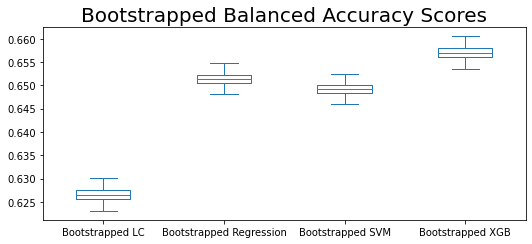

In [101]:
# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
dat = pd.DataFrame({"Bootstrapped LC": B_LC_list, "Bootstrapped Regression": B_list, "Bootstrapped SVM": B_svm_list, "Bootstrapped XGB":B_xgb_list})

# Plot the dataframe
ax = dat.plot(kind='box', title='Bootstrapped Balanced Accuracy Scores', showfliers=False)

# Display the plot
plt.show()

# Monetary Metrics

Here we look at potential metrics for money saved/lost if you used xgboost vs if you used the subgrade. We also run some bootstraps of the test set to get uncertainty bounds.

In [102]:
seed = 0

In [103]:
# Formula

# Approx lost money
# F * (M_bar)

#Change per percent
# -delta_F(+1%) * (M_bar)


#Average Loan Amount
M_bar = data["loan_amnt"].mean()

## XGBoost

In [104]:
splitdata=H.DataSplit(cleaned_data,0.1,0.1,seed=seed)

In [105]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [106]:
# Set up statified data
X_train= trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [107]:
# Fitting the full model - this may take several minutes
xgb_cl = xgb.XGBClassifier(use_label_encoder=False,booster='gbtree',verbosity=0,max_depth=2,eta=0.3,gamma=0)
model = xgb_cl.fit(X_train,y_train)

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [108]:
#ROC cutoff
xgb_val = model.predict_proba(X_valid)[:,1]
ROC=H.ROC_cutoff(xgb_val,y_valid, silence = True)
thresholds = ROC[0]
threshold = thresholds[ROC[1]]

In [109]:
#Check Model Accuracy
xgb_preds = (model.predict_proba(X_test)[:,1] >= threshold).astype(int)
xgb_BA = balanced_accuracy_score(y_test, xgb_preds)
xgb_recal = recall_score(y_test, xgb_preds)
xgb_F1 = f1_score(y_test, xgb_preds)

/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [110]:
print('XGB Balanced Accuracy:',xgb_BA)
print('XGB F1:',xgb_F1)
print('XGB Recall:',xgb_recal)

XGB Balanced Accuracy: 0.6575986835992438
XGB F1: 0.4235712206853239
XGB Recall: 0.6618794580879889


In [111]:
#Number of True/False of predictions
FP_xgboost = confusion_matrix(y_test, xgb_preds)[0,1]
FN_xgboost = confusion_matrix(y_test, xgb_preds)[1,0]
TP_xgboost = confusion_matrix(y_test, xgb_preds)[1,1]
TN_xgboost = confusion_matrix(y_test, xgb_preds)[0,0]

In [112]:
#Money Associated with such predictions
True_ML_xgboost=sum(data["loan_amnt"][y_test.index][np.logical_not(xgb_preds == y_test["loan_status"])])
True_MG_xgboost=sum(data["loan_amnt"][y_test.index][(xgb_preds == y_test["loan_status"])])
True_MTP_xgboost=sum(data["loan_amnt"][y_test.index][(xgb_preds == 1) & (y_test["loan_status"] == 1)])
True_MTN_xgboost=sum(data["loan_amnt"][y_test.index][(xgb_preds == 0) & (y_test["loan_status"] == 0)])
True_MFP_xgboost=sum(data["loan_amnt"][y_test.index][(xgb_preds == 1) & (y_test["loan_status"] == 0)])
True_MFN_xgboost=sum(data["loan_amnt"][y_test.index][(xgb_preds == 0) & (y_test["loan_status"] == 1)])

In [113]:
#Total False predictions
F_xgboost = FP_xgboost + FN_xgboost

In [114]:
#Total True predictions
T_xgboost = TP_xgboost + TN_xgboost

In [115]:
#Approx money lost
ML_xgboost= F_xgboost*M_bar

In [116]:
#Approx money gained
MG_xgboost= T_xgboost*M_bar

## Grade Regression

In [117]:
#Valid responses
data_grade = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]

#Drop column if more than alpha are non-Null
alpha = 0.90

data_grade = data_grade.dropna(axis='columns',thresh = np.ceil(alpha*len(data_grade)))
data_grade = data_grade.dropna()

#Responce

data_grade = data_grade.replace({"Fully Paid":0,"Charged Off" :1})

data_grade = data_grade[["loan_status","sub_grade"]]
def ohe_columns(df, columns):
    """
    :param df: input data in the form of a dataframe
    :param columns: list of columns to encode
    :return: df: dataframe with the encoded columns
    """
    for col in columns:
        df = pd.concat([df.drop([col], axis=1),
                        pd.get_dummies(df[col],
                        drop_first=True, prefix=col)], axis=1)
    return df
    
data_grade = ohe_columns(data_grade,["sub_grade"])

In [118]:
splitdata=H.DataSplit(data_grade,0.1,0.1,seed=seed)

In [119]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [120]:
# Set up statified data
X_train= trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [121]:
log_reg = sm.Logit(y_train, X_train).fit(disp=0)

In [122]:
#Find optimal ROC cutoff
y_pred = log_reg.predict(X_valid)

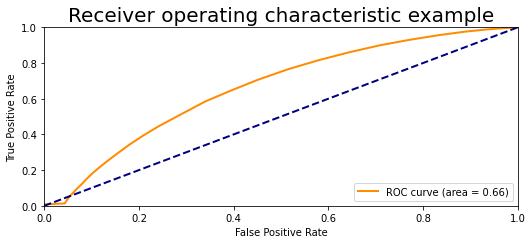

Optimal Threshold: 0.21830914442301846


In [123]:
thresh = H.ROC_cutoff(y_pred, y_valid)

In [124]:
# Get some accuracy metrics
log_reg_preds = (log_reg.predict(X_test) >= thresh[0][thresh[1]]).astype(int)
log_reg_BA = balanced_accuracy_score(y_test, log_reg_preds)
log_reg_recal = recall_score(y_test, log_reg_preds)
log_reg_F1 = f1_score(y_test, log_reg_preds)

In [125]:
print('Log Reg Balanced Accuracy:',log_reg_BA)
print('Log Reg F1:',log_reg_F1)
print('Log Reg Recall:',log_reg_recal)

Log Reg Balanced Accuracy: 0.6274371512980682
Log Reg F1: 0.3918547055586131
Log Reg Recall: 0.6476135765235291


In [126]:
#Number of True/False of predictions
FP_grade = confusion_matrix(y_test, log_reg_preds)[0,1]
FN_grade = confusion_matrix(y_test, log_reg_preds)[1,0]
TP_grade = confusion_matrix(y_test, log_reg_preds)[1,1]
TN_grade = confusion_matrix(y_test, log_reg_preds)[0,0]

In [127]:
#Money Associated with such predictions
True_ML_grade=sum(data["loan_amnt"][y_test.index][np.logical_not(log_reg_preds == y_test["loan_status"])])
True_MG_grade=sum(data["loan_amnt"][y_test.index][(log_reg_preds == y_test["loan_status"])])
True_MTP_grade=sum(data["loan_amnt"][y_test.index][(log_reg_preds == 1) & (y_test["loan_status"] == 1)]) # Well Avioded
True_MTN_grade=sum(data["loan_amnt"][y_test.index][(log_reg_preds == 0) & (y_test["loan_status"] == 0)]) # Well Loaned
True_MFP_grade=sum(data["loan_amnt"][y_test.index][(log_reg_preds == 1) & (y_test["loan_status"] == 0)])
True_MFN_grade=sum(data["loan_amnt"][y_test.index][(log_reg_preds == 0) & (y_test["loan_status"] == 1)])

In [128]:
#Total False predictions
F_grade = FP_grade + FN_grade

In [129]:
#Total True predictions
T_grade = TP_grade + TN_grade

In [130]:
#Approx money lost
ML_grade=F_grade*M_bar

In [131]:
#Approx money gains
MG_grade=T_grade*M_bar

# Useful Quantities

In [132]:
#Change in approx loss
delta_ML = ML_grade - ML_xgboost

In [133]:
#Change in approx gain
delta_MG = MG_xgboost - MG_grade

In [134]:
#Total Money 
M_total=MG_xgboost+ML_xgboost 

In [135]:
#True Money Lost
True_delta_ML = True_ML_grade - True_ML_xgboost

In [136]:
#True money Gained
True_delta_MG = True_MG_xgboost - True_MG_grade

In [137]:
#Well Loaned
True_delta_MTN = True_MTN_xgboost - True_MTN_grade

In [138]:
#Well Avoided
True_delta_MTP = True_MTP_xgboost - True_MTP_grade

In [139]:
#Number of loans
n=len(y_test)

In [140]:
#Difference in BA
perc_diff = (xgb_BA-log_reg_BA)

# Ideas for Metrics

In [141]:
#Change in loss over perc diff and loan numbers
delta_ML_Rate = delta_ML/(n*perc_diff)

In [142]:
#True version of above
True_delta_ML_Rate = True_delta_ML/(n*perc_diff)

In [143]:
#Money Gain per number of loans and percent difference in model?

True_delta_ML_Rate
delta_ML_Rate

15279.077632261378

19939.209943634716

In [144]:
#Money Gain over total money

True_delta_ML/M_total

0.030626869130941384

## Main Metric for consideration

In [145]:
#Big assumption for all of these
# M(+) = sum(M_i*(+)) ~ M_bar*(+)

# What you would need to know/approx to use metri/predictions

# Simple version
## BA percent difference
## Total Money avalible

# Complex version
## Good loan percentage
## Potentailly an approx of one of delta(MTP) or delta(MTN)

In [146]:
# delta(BA) ~ 1/2(delta(MTP)/MP+delta(MTN)/MN)

delta_MTN = M_bar*(TN_xgboost-TN_grade) # Approx Change in Well Loaned
delta_MTP = M_bar*(TP_xgboost-TP_grade) # Approx Change in Well Avoided
N = (TN_xgboost+FP_xgboost)
P = (TP_xgboost+FN_xgboost)

In [147]:
# delta(BA) * M_total ~ 1/2(delta(MTN)((N+P)/N) + delta(MTP)*((N+P)/P))
# Note one of the deltas can be negative and the equations can still be true and positive overal
# Equations will be exact under approximation given above

PGL = N/n #Good loan percentage
PBL = 1-PGL  #Bad loan percentage
delta_MG_a = perc_diff*(M_total)
delta_MG_b = 0.5*(delta_MTN*(PGL)**(-1)+delta_MTP*(PBL)**(-1))

In [148]:
#If we assume delta(MTN) ~ delta(MG)*(N/(N+P)) | delta(MTP) ~ delta(MG)*(P/(N+P)) 
#Meaning model got better in both parts randomly
#Then delta(MG) ~ M_total * delta(BA)

perdiff = 100*(True_delta_MG-delta_MG_a)/((True_delta_MG+delta_MG_a)/2)

In [149]:
perdiff

1.5310053194455324

In [150]:
#Check for simplifing Assumptions

a = True_delta_MTP 
b = True_delta_MG*(P/(N+P))

perdiff = 100*(a-b)/((a+b)/2)
print(perdiff)

a = True_delta_MTN 
b = True_delta_MG*(N/(N+P))

perdiff = 100*(a-b)/((a+b)/2)
print(perdiff)

-16.123023738922406
3.473353094903903


In [151]:
#Compare Truth of more complex Equation
#Only Approx is M_bar approximation

delta_MG_a = perc_diff*(M_total)
delta_MG_c = 0.5*(True_delta_MTN*(PGL)**(-1)+True_delta_MTP*(PBL)**(-1))
perdiff = 100*(delta_MG_a-delta_MG_c)/((delta_MG_a+delta_MG_c)/2)

In [152]:
perdiff

4.329493482019332

In [153]:
#Negative means the grade model did better in the aspect
True_delta_MTN # Change in Well Loaned
True_delta_MTP # Change in Well Avoided
True_delta_MG # Total Monitary Gain (Note counts money loaned that does not default and money not lost to defaults)

42069975.0

8190200.0

50260175.0

## Bootstrap Plots

In [154]:
#Reaquire data for xgboost
splitdata=H.DataSplit(cleaned_data,0.1,0.1,seed=seed)

In [155]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [156]:
# Set up statified data
X_train= trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [157]:
def XGB(X_test,y_test,model):
    xgb_preds = (model.predict_proba(X_test)[:,1] >= 0.1905049).astype(int)
    return sum(data["loan_amnt"][y_test.index][(xgb_preds == 1) & (y_test["loan_status"] == 1)])

In [158]:
B = 1000
n = len(X_test)
B_xgb_list = []
for i in tqdm.tqdm(range(B)):
    B_idx = np.random.choice(range(n), size=n, replace=True)
    B_xgb_list.append(XGB(X_test.iloc[B_idx],y_test.iloc[B_idx],model)/sum(data["loan_amnt"][y_test.iloc[B_idx].index]))

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/Users/duncanblack/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
100%|███████████████████████████████████████| 1000/1000 [01:45<00:00,  9.48it/s]


In [159]:
B_xgb_list = np.array(B_xgb_list)
mean, sigma = np.mean(B_xgb_list), np.std(B_xgb_list)
print("XGB:",scipy.stats.norm.interval(0.95, loc=mean, scale=sigma))
print("XGB:",np.mean(B_xgb_list))
print("XGB:",np.std(B_xgb_list))

XGB: (0.14489207892486608, 0.15003269328215088)
XGB: 0.14746238610350848
XGB: 0.0013114053109733919


In [160]:
#Reaquire data for LC regression

#Valid responses
data_grade = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]

#Drop column if more than alpha are non-Null
alpha = 0.90

data_grade = data_grade.dropna(axis='columns',thresh = np.ceil(alpha*len(data_grade)))
data_grade = data_grade.dropna()

#Responce

data_grade = data_grade.replace({"Fully Paid":0,"Charged Off" :1})

data_grade = data_grade[["loan_status","sub_grade"]]
def ohe_columns(df, columns):
    """
    :param df: input data in the form of a dataframe
    :param columns: list of columns to encode
    :return: df: dataframe with the encoded columns
    """
    for col in columns:
        df = pd.concat([df.drop([col], axis=1),
                        pd.get_dummies(df[col],
                        drop_first=True, prefix=col)], axis=1)
    return df
    
data_grade = ohe_columns(data_grade,["sub_grade"])

In [161]:
splitdata=H.DataSplit(data_grade,0.1,0.1,seed=seed)

In [162]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [163]:
# Set up statified data
X_train= trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [164]:
def Grade_Reg(X_test,y_test,model):
    grade_preds = (model.predict(X_test) >= 0.21830914442301846).astype(int)
    return sum(data["loan_amnt"][y_test.index][(grade_preds == 1) & (y_test["loan_status"] == 1)])

In [165]:
B = 1000
n = len(X_test)
B_LC_list = []
for i in tqdm.tqdm(range(B)):
    B_idx = np.random.choice(range(n), size=n, replace=True)
    B_LC_list.append(Grade_Reg(X_test.iloc[B_idx],y_test.iloc[B_idx],log_reg)/sum(data["loan_amnt"][y_test.iloc[B_idx].index]))

100%|███████████████████████████████████████| 1000/1000 [00:53<00:00, 18.60it/s]


In [166]:
B_LC_list = np.array(B_LC_list)
mean, sigma = np.mean(B_LC_list), np.std(B_LC_list)
scipy.stats.norm.interval(0.95, loc=mean, scale=sigma)
print(np.mean(B_LC_list))
print(np.std(B_LC_list))

(0.13993869631709624, 0.14481264695576365)

0.14237567163642995
0.0012433776021173117


In [167]:
B_diff_list = B_xgb_list - B_LC_list
mean, sigma = np.mean(B_diff_list), np.std(B_diff_list)
scipy.stats.norm.interval(0.95, loc=mean, scale=sigma)
print(np.mean(B_diff_list))
print(np.std(B_diff_list))

(0.0015074209990171483, 0.008666007935139948)

0.005086714467078548
0.0018262036936874402


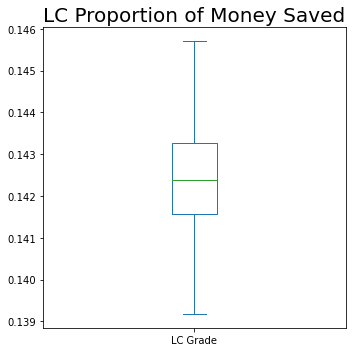

In [168]:
# Set the figure size
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
dat = pd.DataFrame({"LC Grade": B_LC_list})

# Plot the dataframe
ax = dat.plot(kind='box', title='LC Proportion of Money Saved', showfliers=False)

# Display the plot
plt.show()

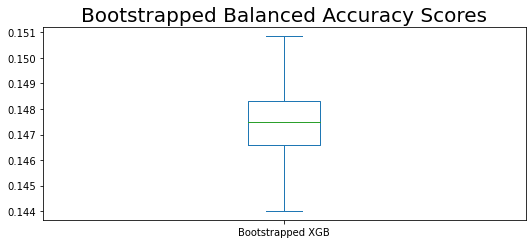

In [169]:
# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
dat = pd.DataFrame({"Bootstrapped XGB": B_xgb_list})

# Plot the dataframe
ax = dat.plot(kind='box', title='Bootstrapped Balanced Accuracy Scores', showfliers=False)

# Display the plot
plt.show()

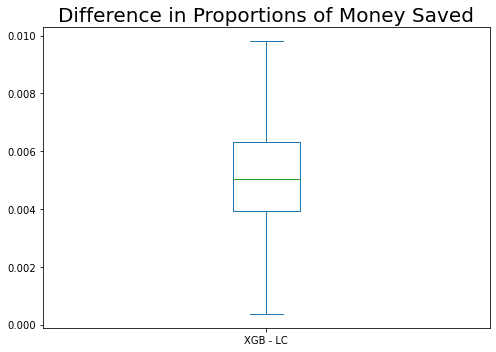

In [170]:
# Set the figure size
plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
dat = pd.DataFrame({"XGB - LC": B_diff_list})

# Plot the dataframe
ax = dat.plot(kind='box', title='Difference in Proportions of Money Saved', showfliers=False)

# Display the plot
plt.show()

In [171]:
#Mean Difference in Proportions of Money Saved Multiplied by total amount of money from lending club dataset

#Seems to be on the order of 10^8

Lending_Club_Total = data["loan_amnt"].sum(skipna=True)
Saved_Money_Percentage = np.array(scipy.stats.norm.interval(0.95, loc=mean, scale=sigma))

Lending_Club_Total*Saved_Money_Percentage
np.mean(Lending_Club_Total*Saved_Money_Percentage)

array([5.12766075e+07, 2.94783931e+08])

173030268.9895185